# CpG-Gene Enrichment Analysis Pipeline
## Overview
Analyze the relationship between genomic *peaks*, *CpG islands*, and gene *transcription start sites* (TSS) in different cell types and conditions. 

>Identify genes with CpG-overlapping peaks near their TSS regions and perform comprehensive comparative analysis.

Purposes:
1. Identify genomic peaks that overlap with CpG islands
2. Analyze the relationship between CpG-associated peaks and gene TSS regions
3. Compare differences in CpG-gene associations between:
   - Different cell types (NSC and Neurons)
   - Different conditions (Exogenous and Endogenous)

Features:
- Filters for standard chromosomes (chr1-22, X, Y)
- Extends CpG islands and TSS regions by customizable distances
- Calculates coverage statistics for peak-CpG overlaps
- Identifies genes with CpG-overlapping peaks near their TSS
- Generates comparative analysis between different conditions

Input:
- Peak files in BED format (`results/consensus_peaks/{cell_type}_{condition}_consensus.bed`)
- CpG islands file in BED format (`DATA/cpg_islands.bed`)
- Gene annotation file in GTF format (`DATA/gencode.vM10.annotation.gtf`)
- Genome size file (`DATA/genome.size`)

Key Parameters:
- `extend_cpg`: Base pairs to extend CpG islands (default: 300bp)
- `extend_tss`: Base pairs to extend TSS regions (default: 2000bp)
- `coverage_threshold`: Minimum percentage overlap required (adjustable, examples use 20% and 80%)

Output Files:
The pipeline generates several output files across multiple directories:

### Main Analysis Output (`results/cpg_gene_analysis/`)
- `{cell_type}_{condition}_cpg_genes.tsv`: Detailed gene-level statistics
- `{cell_type}_common_genes.txt`: Genes common between conditions
- `comparison_summary.txt`: Overall comparison statistics

### Visualization Output (`results/visualizations/`)
- `peak_distribution.png`: Violin plots of peaks per gene
- `distance_distribution.png`: KDE plots of TSS distances
- `{cell_type}_venn.png`: Venn diagrams of condition overlaps
- `{cell_type}_{condition}_top_genes_heatmap.png`: Heatmaps of top genes
- `total_genes_summary.png`: Bar plots of total genes
- `peak_size_distribution.png`: Box plots of peak sizes

### Comprehensive Analysis Output (`results/comprehensive_analysis/`)
- `endo_cpg_coverage_comparison.png`: Comparison of Endo coverage between cell types
- `cpg_target_overlap.png`: Four-way Venn diagram of all conditions
- `endo_coverage_stats.txt`: Statistical analysis of coverage patterns
- `cpg_overlap_stats.txt`: Detailed overlap statistics
- `{cell_type}_exo_enriched_genes.tsv`: Exo vs Endo enrichment analysis
- `common_enriched_genes.txt`: Genes enriched in both cell types

## Main Functions

### Data Processing Functions
1. **get_peaks_with_cpg()**
   - *Identifies peaks overlapping with CpG islands*
   - Calculates coverage statistics
   - Filters based on coverage threshold

2. **get_genes_with_cpg_enrichment()**
   - *Maps CpG-overlapping peaks to nearby genes*
   - Calculates various metrics including:
     - Number of peaks per gene
     - Total coverage
     - Average peak size
     - Minimum distance to TSS

3. **extract_tss_regions()**
   - Extracts TSS locations from GTF file
   - Filters for protein-coding genes
   - Handles both forward and reverse strands

### Analysis Functions
4. **compare_endo_cpg_coverage()**
   - *Compares CpG coverage between NPCs and Neurons*
   - Performs statistical testing
   - Generates coverage distribution plots

5. **analyze_common_cpg_targets()**
   - *Identifies targets common across conditions*
   - Creates four-way Venn diagrams
   - Calculates pairwise overlaps

6. **analyze_exo_vs_endo_enrichment()**
   - Calculates enrichment ratios
   - Identifies significantly enriched genes
   - Finds common enriched genes across cell types

### Visualization Functions
7. **plot_peak_distribution()**
   - Creates violin plots of peak distributions
   - Compares across all conditions

8. **plot_distance_distribution()**
   - Generates KDE plots of TSS distances
   - Shows distribution patterns across conditions

9. **create_venn_diagrams()**
   - Visualizes overlap between conditions
   - Separate diagrams for each cell type

10. **plot_top_genes_heatmap()**
    - Creates heatmaps of top genes
    - Shows normalized coverage scores

### Utility Functions
11. **load_and_process_data()**
    - Loads analysis results
    - Calculates additional metrics
    - Prepares data for visualization

12. **create_comparison_summary()**
    - Generates comparative analysis
    - Identifies condition-specific genes
    - Calculates overlap statistics

## Usage
The pipeline can be run with different coverage thresholds:
```python
# For 20% coverage threshold
get_genes_with_cpg_enrichment(..., coverage_threshold=20)

# For 80% coverage threshold
get_genes_with_cpg_enrichment(..., coverage_threshold=80)
```

Visualizations can be generated using:
```python
generate_all_visualizations(results_dir, visualization_dir)
generate_comprehensive_analysis(results_dir, analysis_dir)
```

# Environment

In [1]:
# Standard library imports
import os
import subprocess
from collections import defaultdict
from pathlib import Path

# Third party imports
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import glob
from IPython.display import Image, display
from venn import venn

wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_CUTandTAG/custom_pipeline'
os.chdir(wd_dir)

current_dir = os.getcwd()


## Local functions

In [2]:
def get_peaks_with_cpg(peak_file, cpg_file, extend=300, coverage_threshold=20):
    """
    Identifies peaks that overlap with CpG islands above a coverage threshold.
    
    Args:
        peak_file: BED file containing peak regions
        cpg_file: BED file containing CpG islands
        extend: Number of base pairs to extend CpG islands (default: 100bp)
        coverage_threshold: Minimum percentage overlap required (default: 20%)
    
    Returns:
        set: Peak coordinates that meet the CpG overlap criteria
    """
    print(f"\nProcessing {peak_file}")
    
    # Validate input files
    if not all(os.path.exists(f) for f in [peak_file, cpg_file]):
        print("Error: Input file(s) missing!")
        return set()
    
    # Filter for standard chromosomes (chr1-22, X, Y)
    standard_chroms = [f"chr{i}" for i in range(1, 23)] + ['chrX', 'chrY']
    
    # Create temporary filtered files
    filtered_peaks = "temp_filtered_peaks.bed"
    filtered_cpg = "temp_filtered_cpg.bed"
    
    # Filter peaks and count
    with open(peak_file) as fin, open(filtered_peaks, 'w') as fout:
        peaks = [line for line in fin if line.split('\t')[0] in standard_chroms]
        fout.writelines(peaks)
        print(f"Peaks after chromosome filtering: {len(peaks)}")
    
    # Filter and extend CpG islands
    with open(cpg_file) as fin, open(filtered_cpg, 'w') as fout:
        fout.writelines(line for line in fin if line.split('\t')[0] in standard_chroms)
    
    # Extend CpG regions and find overlaps using bedtools
    subprocess.run(f"bedtools slop -i {filtered_cpg} -g DATA/genome.size -b {extend} > temp_extended_cpg.bed", shell=True)
    result = subprocess.run(f"bedtools intersect -a {filtered_peaks} -b temp_extended_cpg.bed -wao", 
                          shell=True, capture_output=True, text=True)
    
    # Process overlaps and calculate coverage
    peaks_with_cpg = set()
    coverage_stats = []
    current_peak = {'id': None, 'overlaps': []}
    qualified_peaks = 0
    total_peaks_with_overlap = 0
    
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        peak_id = f"{fields[0]}:{fields[1]}-{fields[2]}"
        peak_length = int(fields[2]) - int(fields[1])
        
        # If we encounter a new peak
        if peak_id != current_peak['id']:
            # Process previous peak if it exists
            if current_peak['overlaps']:
                max_coverage = max(current_peak['overlaps'])
                total_peaks_with_overlap += 1
                if max_coverage >= coverage_threshold:
                    coverage_stats.append(max_coverage)
                    peaks_with_cpg.add(current_peak['id'])
                    qualified_peaks += 1
            
            current_peak = {'id': peak_id, 'overlaps': []}
            
        # Calculate overlap coverage if exists
        if fields[4] != "." and int(fields[-1]) > 0:
            coverage = (int(fields[-1]) / peak_length) * 100
            current_peak['overlaps'].append(coverage)
    
    # Process the last peak
    if current_peak['overlaps']:
        max_coverage = max(current_peak['overlaps'])
        total_peaks_with_overlap += 1
        if max_coverage >= coverage_threshold:
            coverage_stats.append(max_coverage)
            peaks_with_cpg.add(current_peak['id'])
            qualified_peaks += 1
    
    # Print coverage statistics
    if coverage_stats:
        print(f"\nPeaks with any CpG overlap: {total_peaks_with_overlap}")
        print(f"Peaks meeting {coverage_threshold}% coverage threshold: {qualified_peaks}")
        print(f"Coverage range: {min(coverage_stats):.2f}% - {max(coverage_stats):.2f}%")
        print(f"Mean coverage of qualified peaks: {sum(coverage_stats)/len(coverage_stats):.2f}%")
    
    # Cleanup temporary files
    for f in [filtered_peaks, filtered_cpg, "temp_extended_cpg.bed"]:
        if os.path.exists(f):
            os.remove(f)
    
    return peaks_with_cpg

def get_genes_with_cpg_enrichment(peak_file, cpg_file, gtf_file, output_dir, cell_type, condition, 
                                 extend_cpg=300, extend_tss=2000, coverage_threshold=20):
    """
    Identifies genes with CpG-overlapping peaks near their TSS regions.
    """
    print(f"\nAnalyzing {cell_type} {condition} peaks")
    
    # Validate input files
    if not os.path.exists(gtf_file):
        print(f"Error: GTF file not found: {gtf_file}")
        return None
        
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Get peaks overlapping with CpG islands
    cpg_peaks = get_peaks_with_cpg(peak_file, cpg_file, extend=extend_cpg, 
                                  coverage_threshold=coverage_threshold)
    
    if not cpg_peaks:
        print(f"No CpG-overlapping peaks found for {cell_type} {condition}")
        return {'genes': pd.DataFrame(), 'total_peaks': 0}
    
    # 2. Extract and extend TSS regions
    try:
        tss_bed = os.path.join(output_dir, "temp_tss.bed")
        extract_tss_regions(gtf_file, tss_bed)
        
        extended_tss = os.path.join(output_dir, "temp_extended_tss.bed")
        subprocess.run(f"bedtools slop -i {tss_bed} -g DATA/genome.size -b {extend_tss} > {extended_tss}",
                      shell=True, check=True)
        
        # 3. Write CpG-overlapping peaks to temporary file
        temp_peaks = os.path.join(output_dir, "temp_cpg_peaks.bed")
        with open(temp_peaks, 'w') as f:
            for peak in cpg_peaks:
                chrom, pos = peak.split(':')
                start, end = pos.split('-')
                f.write(f"{chrom}\t{start}\t{end}\n")
        
        # 4. Find overlaps between peaks and TSS regions
        result = subprocess.run(
            f"bedtools intersect -a {extended_tss} -b {temp_peaks} -wo",
            shell=True, capture_output=True, text=True, check=True
        )
        
        # 5. Process results
        gene_data = defaultdict(lambda: {
            'peaks': set(),
            'total_peak_coverage': 0,
            'distance_to_tss': []
        })
        
        for line in result.stdout.strip().split('\n'):
            if not line:
                continue
            
            fields = line.split('\t')
            gene_name = fields[3]
            tss_pos = int(fields[1]) + extend_tss
            peak_start = int(fields[5])
            peak_end = int(fields[6])
            peak_id = f"{fields[4]}:{fields[5]}-{fields[6]}"
            
            peak_center = (peak_start + peak_end) // 2
            distance = abs(peak_center - tss_pos)
            
            gene_data[gene_name]['peaks'].add(peak_id)
            gene_data[gene_name]['total_peak_coverage'] += int(fields[-1])
            gene_data[gene_name]['distance_to_tss'].append(distance)
        
        # 6. Create summary DataFrame
        summary_data = []
        for gene, data in gene_data.items():
            if data['peaks']:  # Only include genes with peaks
                summary_data.append({
                    'gene_name': gene,
                    'num_peaks': len(data['peaks']),
                    'total_coverage': data['total_peak_coverage'],
                    'avg_peak_size': data['total_peak_coverage'] / len(data['peaks']),
                    'min_distance_to_tss': min(data['distance_to_tss']),
                    'peaks': ','.join(data['peaks'])
                })
        
        df = pd.DataFrame(summary_data)
        
        # 7. Save results
        if not df.empty:
            output_file = os.path.join(output_dir, f"{cell_type}_{condition}_cpg_genes.tsv")
            df.sort_values('num_peaks', ascending=False).to_csv(output_file, sep='\t', index=False)
            print(f"Found {len(df)} genes with CpG-overlapping peaks")
            print(f"Results saved to: {output_file}")
        else:
            print(f"No genes found with CpG-overlapping peaks for {cell_type} {condition}")
        
        return {'genes': df, 'total_peaks': len(cpg_peaks)}
        
    except Exception as e:
        print(f"Error processing gene enrichment: {str(e)}")
        return {'genes': pd.DataFrame(), 'total_peaks': 0}
    finally:
        # Cleanup temporary files
        for f in [tss_bed, extended_tss, temp_peaks]:
            if os.path.exists(f):
                os.remove(f)

def extract_tss_regions(gtf_file, output_bed):
    """Extracts TSS regions from GTF file."""
    with open(gtf_file) as fin, open(output_bed, 'w') as fout:
        for line in fin:
            if line.startswith('#'):
                continue
            
            fields = line.strip().split('\t')
            if fields[2] != "gene":
                continue
            
            # Parse gene information
            info_dict = {}
            for item in fields[8].rstrip(';').split('; '):
                try:
                    key, value = item.strip().split(' ', 1)
                    info_dict[key] = value.strip('"')
                except ValueError:
                    continue
            
            gene_name = info_dict.get('gene_name', '')
            gene_type = info_dict.get('gene_type', '')
            
            if not gene_name or gene_type != "protein_coding":
                continue
            
            # Get TSS position
            chrom = fields[0]
            if fields[6] == '+':
                tss_pos = int(fields[3])
                fout.write(f"{chrom}\t{tss_pos-1}\t{tss_pos}\t{gene_name}\n")
            else:
                tss_pos = int(fields[4])
                fout.write(f"{chrom}\t{tss_pos-1}\t{tss_pos}\t{gene_name}\n")

def create_comparison_summary(results, output_dir):
    """Creates a summary of gene overlaps between conditions."""
    summary_file = os.path.join(output_dir, "comparison_summary.txt")
    
    with open(summary_file, 'w') as f:
        for cell_type in results:
            exo_genes = set(results[cell_type]['Exo']['genes']['gene_name']) if not results[cell_type]['Exo']['genes'].empty else set()
            endo_genes = set(results[cell_type]['Endo']['genes']['gene_name']) if not results[cell_type]['Endo']['genes'].empty else set()
            
            common_genes = exo_genes & endo_genes
            
            f.write(f"\n{cell_type} Analysis:\n")
            f.write(f"Exogenous-specific genes: {len(exo_genes - common_genes)}\n")
            f.write(f"Endogenous-specific genes: {len(endo_genes - common_genes)}\n")
            f.write(f"Common genes: {len(common_genes)}\n")
            
            if common_genes:
                common_genes_file = os.path.join(output_dir, f"{cell_type}_common_genes.txt")
                with open(common_genes_file, 'w') as cf:
                    for gene in sorted(common_genes):
                        cf.write(f"{gene}\n")

In [3]:
def load_and_process_data(results_dir):
    """
    Load and process data with additional CpG coverage calculations.
    """
    cell_types = ['NSC', 'Neuron']  # NSC is equivalent to NPCs
    conditions = ['Exo', 'Endo']
    data = {}
    
    for cell_type in cell_types:
        data[cell_type] = {}
        for condition in conditions:
            file_path = os.path.join(results_dir, f"{cell_type}_{condition}_cpg_genes.tsv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path, sep='\t')
                # Calculate CpG coverage percentage
                if 'total_coverage' in df.columns:
                    df['cpg_coverage_percent'] = (df['total_coverage'] / df['total_coverage'].max()) * 100
                data[cell_type][condition] = df
            else:
                print(f"Warning: Missing file {file_path}")
                data[cell_type][condition] = pd.DataFrame()
    
    return data

def compare_endo_cpg_coverage(data, output_dir):
    """
    Compare CpG islands coverage of Endo MeCP2 between NPCs and Neurons.
    """
    # Extract Endo data for both cell types
    npc_endo = data['NSC']['Endo']
    neuron_endo = data['Neuron']['Endo']
    
    # Create comparison plots
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Coverage Distribution
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=npc_endo['cpg_coverage_percent'], label='NPCs', color='blue')
    sns.kdeplot(data=neuron_endo['cpg_coverage_percent'], label='Neurons', color='red')
    plt.xlabel('CpG Coverage (%)')
    plt.ylabel('Density')
    plt.title('Endo MeCP2 CpG Coverage Distribution')
    plt.legend()
    
    # Plot 2: Box Plot
    plt.subplot(1, 2, 2)
    plot_data = pd.concat([
        pd.DataFrame({'Cell Type': 'NPCs', 'Coverage': npc_endo['cpg_coverage_percent']}),
        pd.DataFrame({'Cell Type': 'Neurons', 'Coverage': neuron_endo['cpg_coverage_percent']})
    ])
    sns.boxplot(data=plot_data, x='Cell Type', y='Coverage')
    plt.title('CpG Coverage Comparison')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'endo_cpg_coverage_comparison.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Statistical comparison using the correct function name
    stat_result = stats.mannwhitneyu(npc_endo['cpg_coverage_percent'],
                                   neuron_endo['cpg_coverage_percent'],
                                   alternative='two-sided')
    
    # Save statistical results
    with open(os.path.join(output_dir, 'endo_coverage_stats.txt'), 'w') as f:
        f.write(f"Mann-Whitney U test results:\n")
        f.write(f"Statistic: {stat_result.statistic}\n")
        f.write(f"p-value: {stat_result.pvalue}\n")
        f.write(f"\nSummary Statistics:\n")
        f.write(f"NPCs mean coverage: {npc_endo['cpg_coverage_percent'].mean():.2f}%\n")
        f.write(f"Neurons mean coverage: {neuron_endo['cpg_coverage_percent'].mean():.2f}%\n")
        f.write(f"NPCs median coverage: {npc_endo['cpg_coverage_percent'].median():.2f}%\n")
        f.write(f"Neurons median coverage: {neuron_endo['cpg_coverage_percent'].median():.2f}%\n")

def analyze_common_cpg_targets(data, output_dir):
    """
    Analyze CpG targets common between all four experimental groups.
    """
    # Extract gene sets
    npc_endo = set(data['NSC']['Endo']['gene_name'])
    neuron_endo = set(data['Neuron']['Endo']['gene_name'])
    npc_exo = set(data['NSC']['Exo']['gene_name'])
    neuron_exo = set(data['Neuron']['Exo']['gene_name'])
    
    # Calculate common targets across all groups
    all_common = npc_endo.intersection(neuron_endo, npc_exo, neuron_exo)
    all_unique = npc_endo.union(neuron_endo, npc_exo, neuron_exo)
    
    # Calculate percentage of common targets
    common_percent = (len(all_common) / len(all_unique)) * 100
    
    # Create the 4-way Venn diagram
    plt.figure(figsize=(10, 10))
    venn({
        'NSC Endo': npc_endo,
        'Neuron Endo': neuron_endo,
        'NSC Exo': npc_exo,
        'Neuron Exo': neuron_exo
    })
    plt.title('CpG Targets Across All Groups')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cpg_target_overlap.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save detailed overlap statistics
    with open(os.path.join(output_dir, 'cpg_overlap_stats.txt'), 'w') as f:
        f.write("CpG Target Statistics:\n")
        f.write("-" * 50 + "\n")
        f.write(f"NSC Endo targets: {len(npc_endo)}\n")
        f.write(f"Neuron Endo targets: {len(neuron_endo)}\n")
        f.write(f"NSC Exo targets: {len(npc_exo)}\n")
        f.write(f"Neuron Exo targets: {len(neuron_exo)}\n")
        f.write("-" * 50 + "\n")
        f.write(f"Total unique targets: {len(all_unique)}\n")
        f.write(f"Common targets (all groups): {len(all_common)} ({common_percent:.2f}%)\n")
        
        # Calculate pairwise overlaps
        pairs = [
            ('NSC Endo', 'Neuron Endo', npc_endo, neuron_endo),
            ('NSC Endo', 'NSC Exo', npc_endo, npc_exo),
            ('NSC Endo', 'Neuron Exo', npc_endo, neuron_exo),
            ('Neuron Endo', 'NSC Exo', neuron_endo, npc_exo),
            ('Neuron Endo', 'Neuron Exo', neuron_endo, neuron_exo),
            ('NSC Exo', 'Neuron Exo', npc_exo, neuron_exo)
        ]
        
        f.write("\nPairwise Overlaps:\n")
        f.write("-" * 50 + "\n")
        for label1, label2, set1, set2 in pairs:
            overlap = len(set1.intersection(set2))
            total = len(set1.union(set2))
            percent = (overlap / total) * 100
            f.write(f"{label1} vs {label2}: {overlap} ({percent:.2f}%)\n")
        
        # Calculate group-specific targets
        f.write("\nGroup-Specific Targets:\n")
        f.write("-" * 50 + "\n")
        nsc_endo_specific = len(npc_endo - (neuron_endo | npc_exo | neuron_exo))
        neuron_endo_specific = len(neuron_endo - (npc_endo | npc_exo | neuron_exo))
        nsc_exo_specific = len(npc_exo - (npc_endo | neuron_endo | neuron_exo))
        neuron_exo_specific = len(neuron_exo - (npc_endo | neuron_endo | npc_exo))
        
        f.write(f"NSC Endo-specific: {nsc_endo_specific}\n")
        f.write(f"Neuron Endo-specific: {neuron_endo_specific}\n")
        f.write(f"NSC Exo-specific: {nsc_exo_specific}\n")
        f.write(f"Neuron Exo-specific: {neuron_exo_specific}\n")

def analyze_exo_vs_endo_enrichment(data, output_dir):
    """
    Analyze enrichment of Exo vs Endo MeCP2 CpG coverage.
    """
    enriched_genes = {'NSC': [], 'Neuron': []}
    
    for cell_type in ['NSC', 'Neuron']:
        exo_df = data[cell_type]['Exo']
        endo_df = data[cell_type]['Endo']
        
        # Merge Exo and Endo data
        merged = pd.merge(exo_df, endo_df, 
                         on='gene_name', 
                         suffixes=('_exo', '_endo'))
        
        # Calculate enrichment ratio
        merged['enrichment_ratio'] = merged['total_coverage_exo'] / merged['total_coverage_endo']
        
        # Filter for significantly enriched genes (e.g., ratio > 2)
        enriched = merged[merged['enrichment_ratio'] > 2].sort_values('enrichment_ratio', ascending=False)
        enriched_genes[cell_type] = enriched
        
        # Save enriched genes list
        enriched.to_csv(os.path.join(output_dir, f'{cell_type}_exo_enriched_genes.tsv'), 
                       sep='\t', index=False)
    
    # Find common enriched genes
    common_enriched = set(enriched_genes['NSC']['gene_name']).intersection(
        set(enriched_genes['Neuron']['gene_name']))
    
    with open(os.path.join(output_dir, 'common_enriched_genes.txt'), 'w') as f:
        f.write("Genes enriched in Exo vs Endo in both NPCs and Neurons:\n")
        for gene in sorted(common_enriched):
            f.write(f"{gene}\n")

def generate_comprehensive_analysis(results_dir, output_dir):
    """
    Generate all analyses and visualizations.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Load data
    data = load_and_process_data(results_dir)
    
    # Generate all analyses
    compare_endo_cpg_coverage(data, output_dir)
    analyze_common_cpg_targets(data, output_dir)
    analyze_exo_vs_endo_enrichment(data, output_dir)
    
    print(f"All analyses have been saved to: {output_dir}")

# Run analysis

## 20% coverage threshold

In [4]:
"""Analyzes CpG-gene enrichment for all conditions."""
# Setup paths
cpg_file = "DATA/cpg_islands.bed"
gtf_file = "DATA/gencode.vM10.annotation.gtf"
output_dir = "results/cpg_gene_analysis"
os.makedirs(output_dir, exist_ok=True)

results = {}

for cell_type in ['NSC', 'Neuron']:
    results[cell_type] = {}
    for condition in ['Exo', 'Endo']:
        peak_file = f"results/consensus_peaks/{cell_type}_{condition}_consensus.bed"
        
        result = get_genes_with_cpg_enrichment(
            peak_file=peak_file,
            cpg_file=cpg_file,
            gtf_file=gtf_file,
            output_dir=output_dir,
            cell_type=cell_type,
            condition=condition,
            extend_cpg=300,
            extend_tss=2000,
            coverage_threshold=20
        )
        
        if result is not None:
            results[cell_type][condition] = result
        else:
            print(f"Skipping comparison for {cell_type} {condition} due to processing error")
            results[cell_type][condition] = {'genes': pd.DataFrame(), 'total_peaks': 0}

create_comparison_summary(results, output_dir)


Analyzing NSC Exo peaks

Processing results/consensus_peaks/NSC_Exo_consensus.bed
Peaks after chromosome filtering: 13473



Peaks with any CpG overlap: 4146
Peaks meeting 20% coverage threshold: 4113
Coverage range: 20.33% - 100.00%
Mean coverage of qualified peaks: 95.35%
Found 4021 genes with CpG-overlapping peaks
Results saved to: results/cpg_gene_analysis/NSC_Exo_cpg_genes.tsv

Analyzing NSC Endo peaks

Processing results/consensus_peaks/NSC_Endo_consensus.bed
Peaks after chromosome filtering: 23792

Peaks with any CpG overlap: 7655
Peaks meeting 20% coverage threshold: 7589
Coverage range: 20.07% - 100.00%
Mean coverage of qualified peaks: 96.02%
Found 7007 genes with CpG-overlapping peaks
Results saved to: results/cpg_gene_analysis/NSC_Endo_cpg_genes.tsv

Analyzing Neuron Exo peaks

Processing results/consensus_peaks/Neuron_Exo_consensus.bed
Peaks after chromosome filtering: 61261

Peaks with any CpG overlap: 11847
Peaks meeting 20% coverage threshold: 11715
Coverage range: 20.00% - 100.00%
Mean coverage of qualified peaks: 97.33%
Found 9520 genes with CpG-overlapping peaks
Results saved to: results/

## 80% coverage threshold

In [5]:
"""Analyzes CpG-gene enrichment for all conditions."""
# Setup paths
cpg_file = "DATA/cpg_islands.bed"
gtf_file = "DATA/gencode.vM10.annotation.gtf"
output_dir = "results/cpg_gene_analysis"
os.makedirs(output_dir, exist_ok=True)

results = {}

for cell_type in ['NSC', 'Neuron']:
    results[cell_type] = {}
    for condition in ['Exo', 'Endo']:
        peak_file = f"results/consensus_peaks/{cell_type}_{condition}_consensus.bed"
        
        result = get_genes_with_cpg_enrichment(
            peak_file=peak_file,
            cpg_file=cpg_file,
            gtf_file=gtf_file,
            output_dir=output_dir,
            cell_type=cell_type,
            condition=condition,
            extend_cpg=300,
            extend_tss=2000,
            coverage_threshold=80
        )
        
        if result is not None:
            results[cell_type][condition] = result
        else:
            print(f"Skipping comparison for {cell_type} {condition} due to processing error")
            results[cell_type][condition] = {'genes': pd.DataFrame(), 'total_peaks': 0}

create_comparison_summary(results, output_dir)


Analyzing NSC Exo peaks

Processing results/consensus_peaks/NSC_Exo_consensus.bed
Peaks after chromosome filtering: 13473

Peaks with any CpG overlap: 4146
Peaks meeting 80% coverage threshold: 3732
Coverage range: 80.00% - 100.00%
Mean coverage of qualified peaks: 98.83%
Found 3677 genes with CpG-overlapping peaks
Results saved to: results/cpg_gene_analysis/NSC_Exo_cpg_genes.tsv

Analyzing NSC Endo peaks

Processing results/consensus_peaks/NSC_Endo_consensus.bed
Peaks after chromosome filtering: 23792

Peaks with any CpG overlap: 7655
Peaks meeting 80% coverage threshold: 6990
Coverage range: 80.00% - 100.00%
Mean coverage of qualified peaks: 99.12%
Found 6574 genes with CpG-overlapping peaks
Results saved to: results/cpg_gene_analysis/NSC_Endo_cpg_genes.tsv

Analyzing Neuron Exo peaks

Processing results/consensus_peaks/Neuron_Exo_consensus.bed
Peaks after chromosome filtering: 61261

Peaks with any CpG overlap: 11847
Peaks meeting 80% coverage threshold: 11123
Coverage range: 80.06

# Visualization

## Local functions

In [6]:
def load_data(results_dir):
    """
    Load all result files into a dictionary of DataFrames.
    
    Args:
        results_dir (str): Path to the results directory
    
    Returns:
        dict: Nested dictionary containing DataFrames for each cell type and condition
    """
    cell_types = ['NSC', 'Neuron']
    conditions = ['Exo', 'Endo']
    data = {}
    
    for cell_type in cell_types:
        data[cell_type] = {}
        for condition in conditions:
            file_path = os.path.join(results_dir, f"{cell_type}_{condition}_cpg_genes.tsv")
            if os.path.exists(file_path):
                data[cell_type][condition] = pd.read_csv(file_path, sep='\t')
            else:
                print(f"Warning: Missing file {file_path}")
                data[cell_type][condition] = pd.DataFrame()
                
    return data

def plot_peak_distribution(data, output_dir):
    """
    Create violin plots showing the distribution of peaks per gene.
    """
    plt.figure(figsize=(10, 6))
    data_points = []
    
    for cell_type in data:
        for condition in data[cell_type]:
            if not data[cell_type][condition].empty:
                peak_counts = data[cell_type][condition]['num_peaks']
                label = f"{cell_type}-{condition}"
                data_points.extend([(x, label) for x in peak_counts])
    
    if data_points:
        df = pd.DataFrame(data_points, columns=['Peaks', 'Group'])
        sns.violinplot(data=df, x='Group', y='Peaks')
        plt.xticks(rotation=45)
        plt.title('Distribution of CpG-overlapping Peaks per Gene')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'peak_distribution.png'), dpi=300, bbox_inches='tight')
        plt.close()

def plot_distance_distribution(data, output_dir):
    """
    Create KDE plots showing the distribution of distances to TSS.
    """
    plt.figure(figsize=(12, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    color_idx = 0
    
    for cell_type in data:
        for condition in data[cell_type]:
            if not data[cell_type][condition].empty:
                distances = data[cell_type][condition]['min_distance_to_tss']
                sns.kdeplot(data=distances, label=f"{cell_type}-{condition}",
                          color=colors[color_idx])
                color_idx += 1
    
    plt.xlabel('Distance to TSS (bp)')
    plt.ylabel('Density')
    plt.title('Distribution of Minimum Distances to TSS')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'distance_distribution.png'), dpi=300, bbox_inches='tight')
    plt.close()

def create_venn_diagrams(data, output_dir):
    """
    Create Venn diagrams showing overlap between conditions for each cell type.
    """
    colors = {'NSC': ['#1f77b4', '#2ca02c'], 'Neuron': ['#ff7f0e', '#d62728']}
    
    for cell_type in data:
        plt.figure(figsize=(8, 8))
        
        exo_genes = set(data[cell_type]['Exo']['gene_name']) if not data[cell_type]['Exo'].empty else set()
        endo_genes = set(data[cell_type]['Endo']['gene_name']) if not data[cell_type]['Endo'].empty else set()
        
        # Create Venn diagram
        venn2([exo_genes, endo_genes],
              set_labels=('Exogenous', 'Endogenous'),
              set_colors=colors[cell_type])
        
        # Add title separately
        plt.title(f'{cell_type} Gene Overlap')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{cell_type}_venn.png'), dpi=300, bbox_inches='tight')
        plt.close()

def plot_top_genes_heatmap(data, output_dir, n_top=50):
    """
    Create heatmap showing peak coverage for top genes.
    """
    for cell_type in data:
        for condition in data[cell_type]:
            if not data[cell_type][condition].empty:
                df = data[cell_type][condition]
                
                # Get top genes by total coverage
                top_genes = df.nlargest(n_top, 'total_coverage')
                
                # Create a normalized coverage score
                coverage_scores = top_genes[['num_peaks', 'total_coverage']].values
                normalized_scores = (coverage_scores - coverage_scores.min(axis=0)) / \
                                 (coverage_scores.max(axis=0) - coverage_scores.min(axis=0))
                
                plt.figure(figsize=(10, 12))
                sns.heatmap(normalized_scores,
                          cmap='YlOrRd',
                          xticklabels=['Peak Count', 'Coverage'],
                          yticklabels=top_genes['gene_name'],
                          cbar_kws={'label': 'Normalized Score'})
                
                plt.title(f'Top {n_top} Genes - {cell_type} {condition}')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f'{cell_type}_{condition}_top_genes_heatmap.png'),
                          dpi=300, bbox_inches='tight')
                plt.close()

def create_summary_statistics(data, output_dir):
    """
    Generate and save summary statistics.
    """
    summary_stats = []
    
    for cell_type in data:
        for condition in data[cell_type]:
            if not data[cell_type][condition].empty:
                df = data[cell_type][condition]
                stats = {
                    'Cell Type': cell_type,
                    'Condition': condition,
                    'Total Genes': len(df),
                    'Mean Peaks per Gene': df['num_peaks'].mean(),
                    'Median Peaks per Gene': df['num_peaks'].median(),
                    'Mean Distance to TSS': df['min_distance_to_tss'].mean(),
                    'Median Distance to TSS': df['min_distance_to_tss'].median(),
                    'Total Peak Coverage': df['total_coverage'].sum(),
                    'Mean Peak Coverage': df['total_coverage'].mean()
                }
                summary_stats.append(stats)
    
    if summary_stats:
        stats_df = pd.DataFrame(summary_stats)
        stats_df.to_csv(os.path.join(output_dir, 'summary_statistics.tsv'), sep='\t', index=False)
        
        # Create summary plots
        plt.figure(figsize=(10, 6))
        sns.barplot(data=stats_df, x='Cell Type', y='Total Genes', hue='Condition')
        plt.title('Total Genes with CpG-overlapping Peaks')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'total_genes_summary.png'), dpi=300, bbox_inches='tight')
        plt.close()

def plot_peak_size_distribution(data, output_dir):
    """
    Create boxplots showing the distribution of peak sizes.
    """
    plt.figure(figsize=(10, 6))
    peak_sizes = []
    
    for cell_type in data:
        for condition in data[cell_type]:
            if not data[cell_type][condition].empty:
                sizes = data[cell_type][condition]['avg_peak_size']
                labels = [f"{cell_type}-{condition}"] * len(sizes)
                peak_sizes.extend(list(zip(sizes, labels)))
    
    if peak_sizes:
        df = pd.DataFrame(peak_sizes, columns=['Size', 'Group'])
        sns.boxplot(data=df, x='Group', y='Size')
        plt.xticks(rotation=45)
        plt.title('Distribution of Peak Sizes')
        plt.ylabel('Peak Size (bp)')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'peak_size_distribution.png'), dpi=300, bbox_inches='tight')
        plt.close()

def generate_all_visualizations(results_dir, output_dir):
    """
    Generate all visualization plots.
    
    Args:
        results_dir (str): Directory containing the analysis results
        output_dir (str): Directory to save the visualizations
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load all data
    data = load_data(results_dir)
    
    # Generate all plots
    plot_peak_distribution(data, output_dir)
    plot_distance_distribution(data, output_dir)
    create_venn_diagrams(data, output_dir)
    plot_top_genes_heatmap(data, output_dir)
    create_summary_statistics(data, output_dir)
    plot_peak_size_distribution(data, output_dir)
    
    print(f"All visualizations have been saved to: {output_dir}")

## Visualizations 1 

In [7]:
# Set up paths
results_dir = "results/cpg_gene_analysis"
visualization_dir = "results/visualizations"

# Generate all visualizations
generate_all_visualizations(results_dir, visualization_dir)

All visualizations have been saved to: results/visualizations


Displaying generated visualizations:

peak_size_distribution.png:


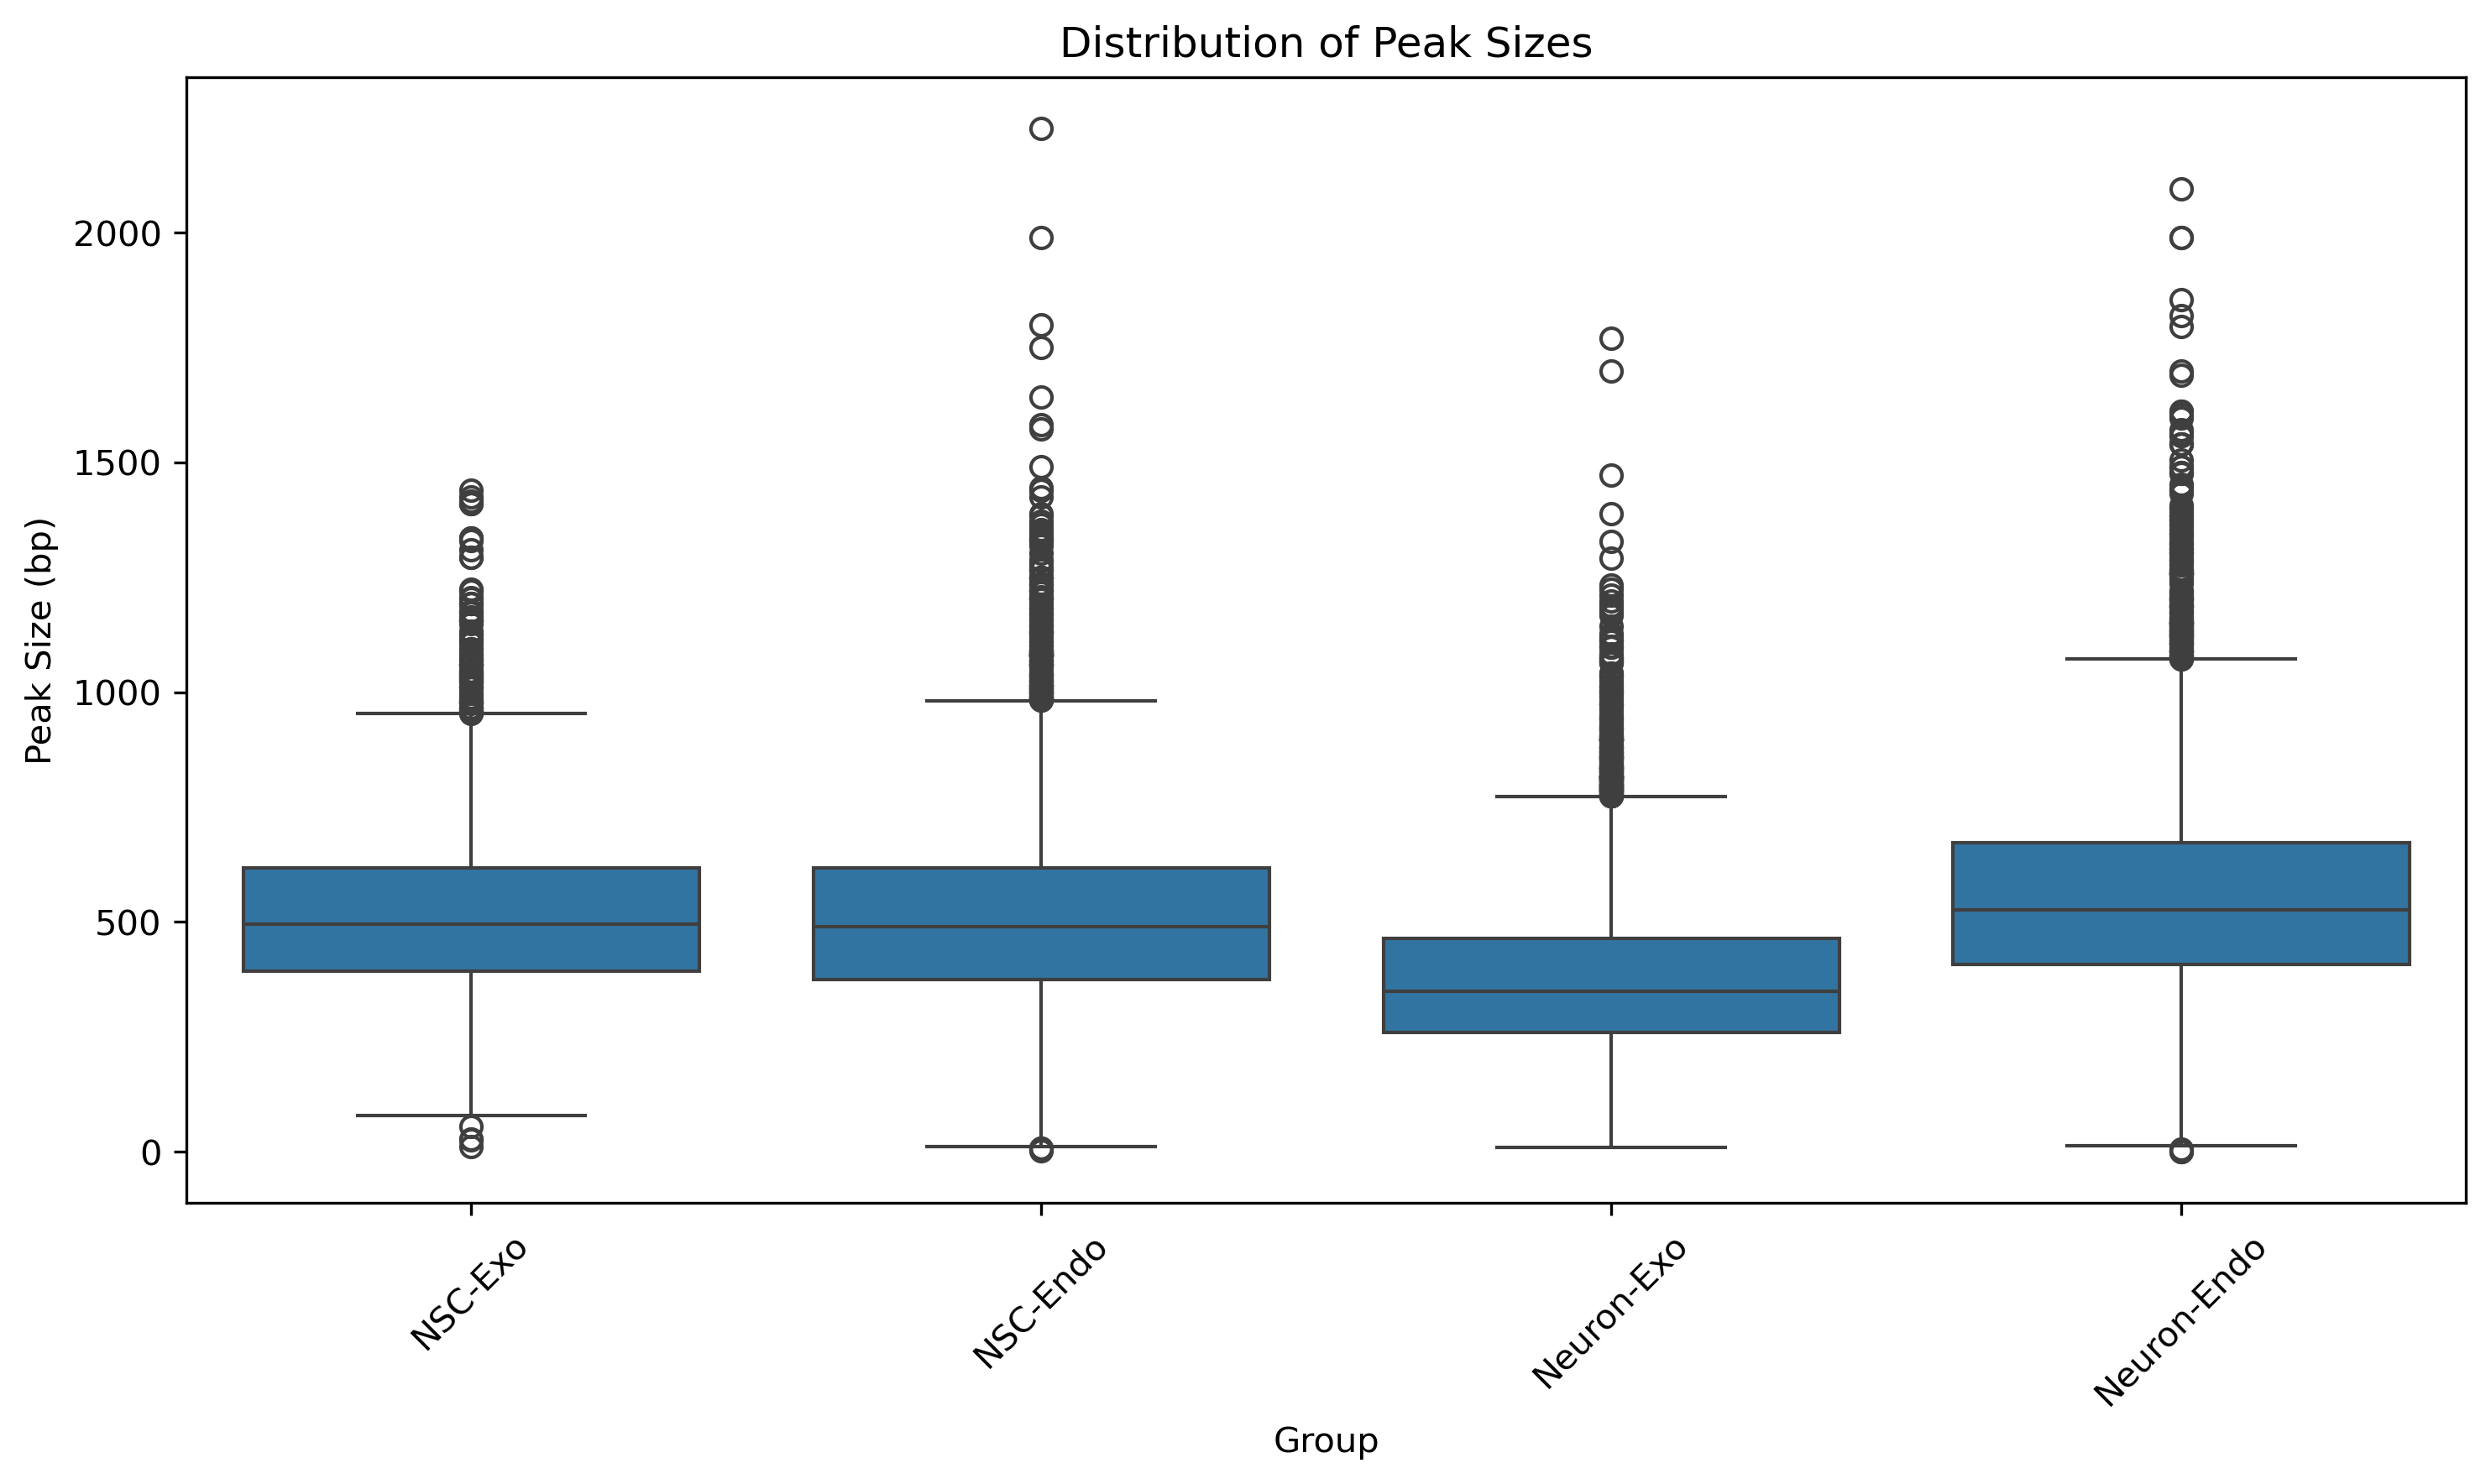


total_genes_summary.png:


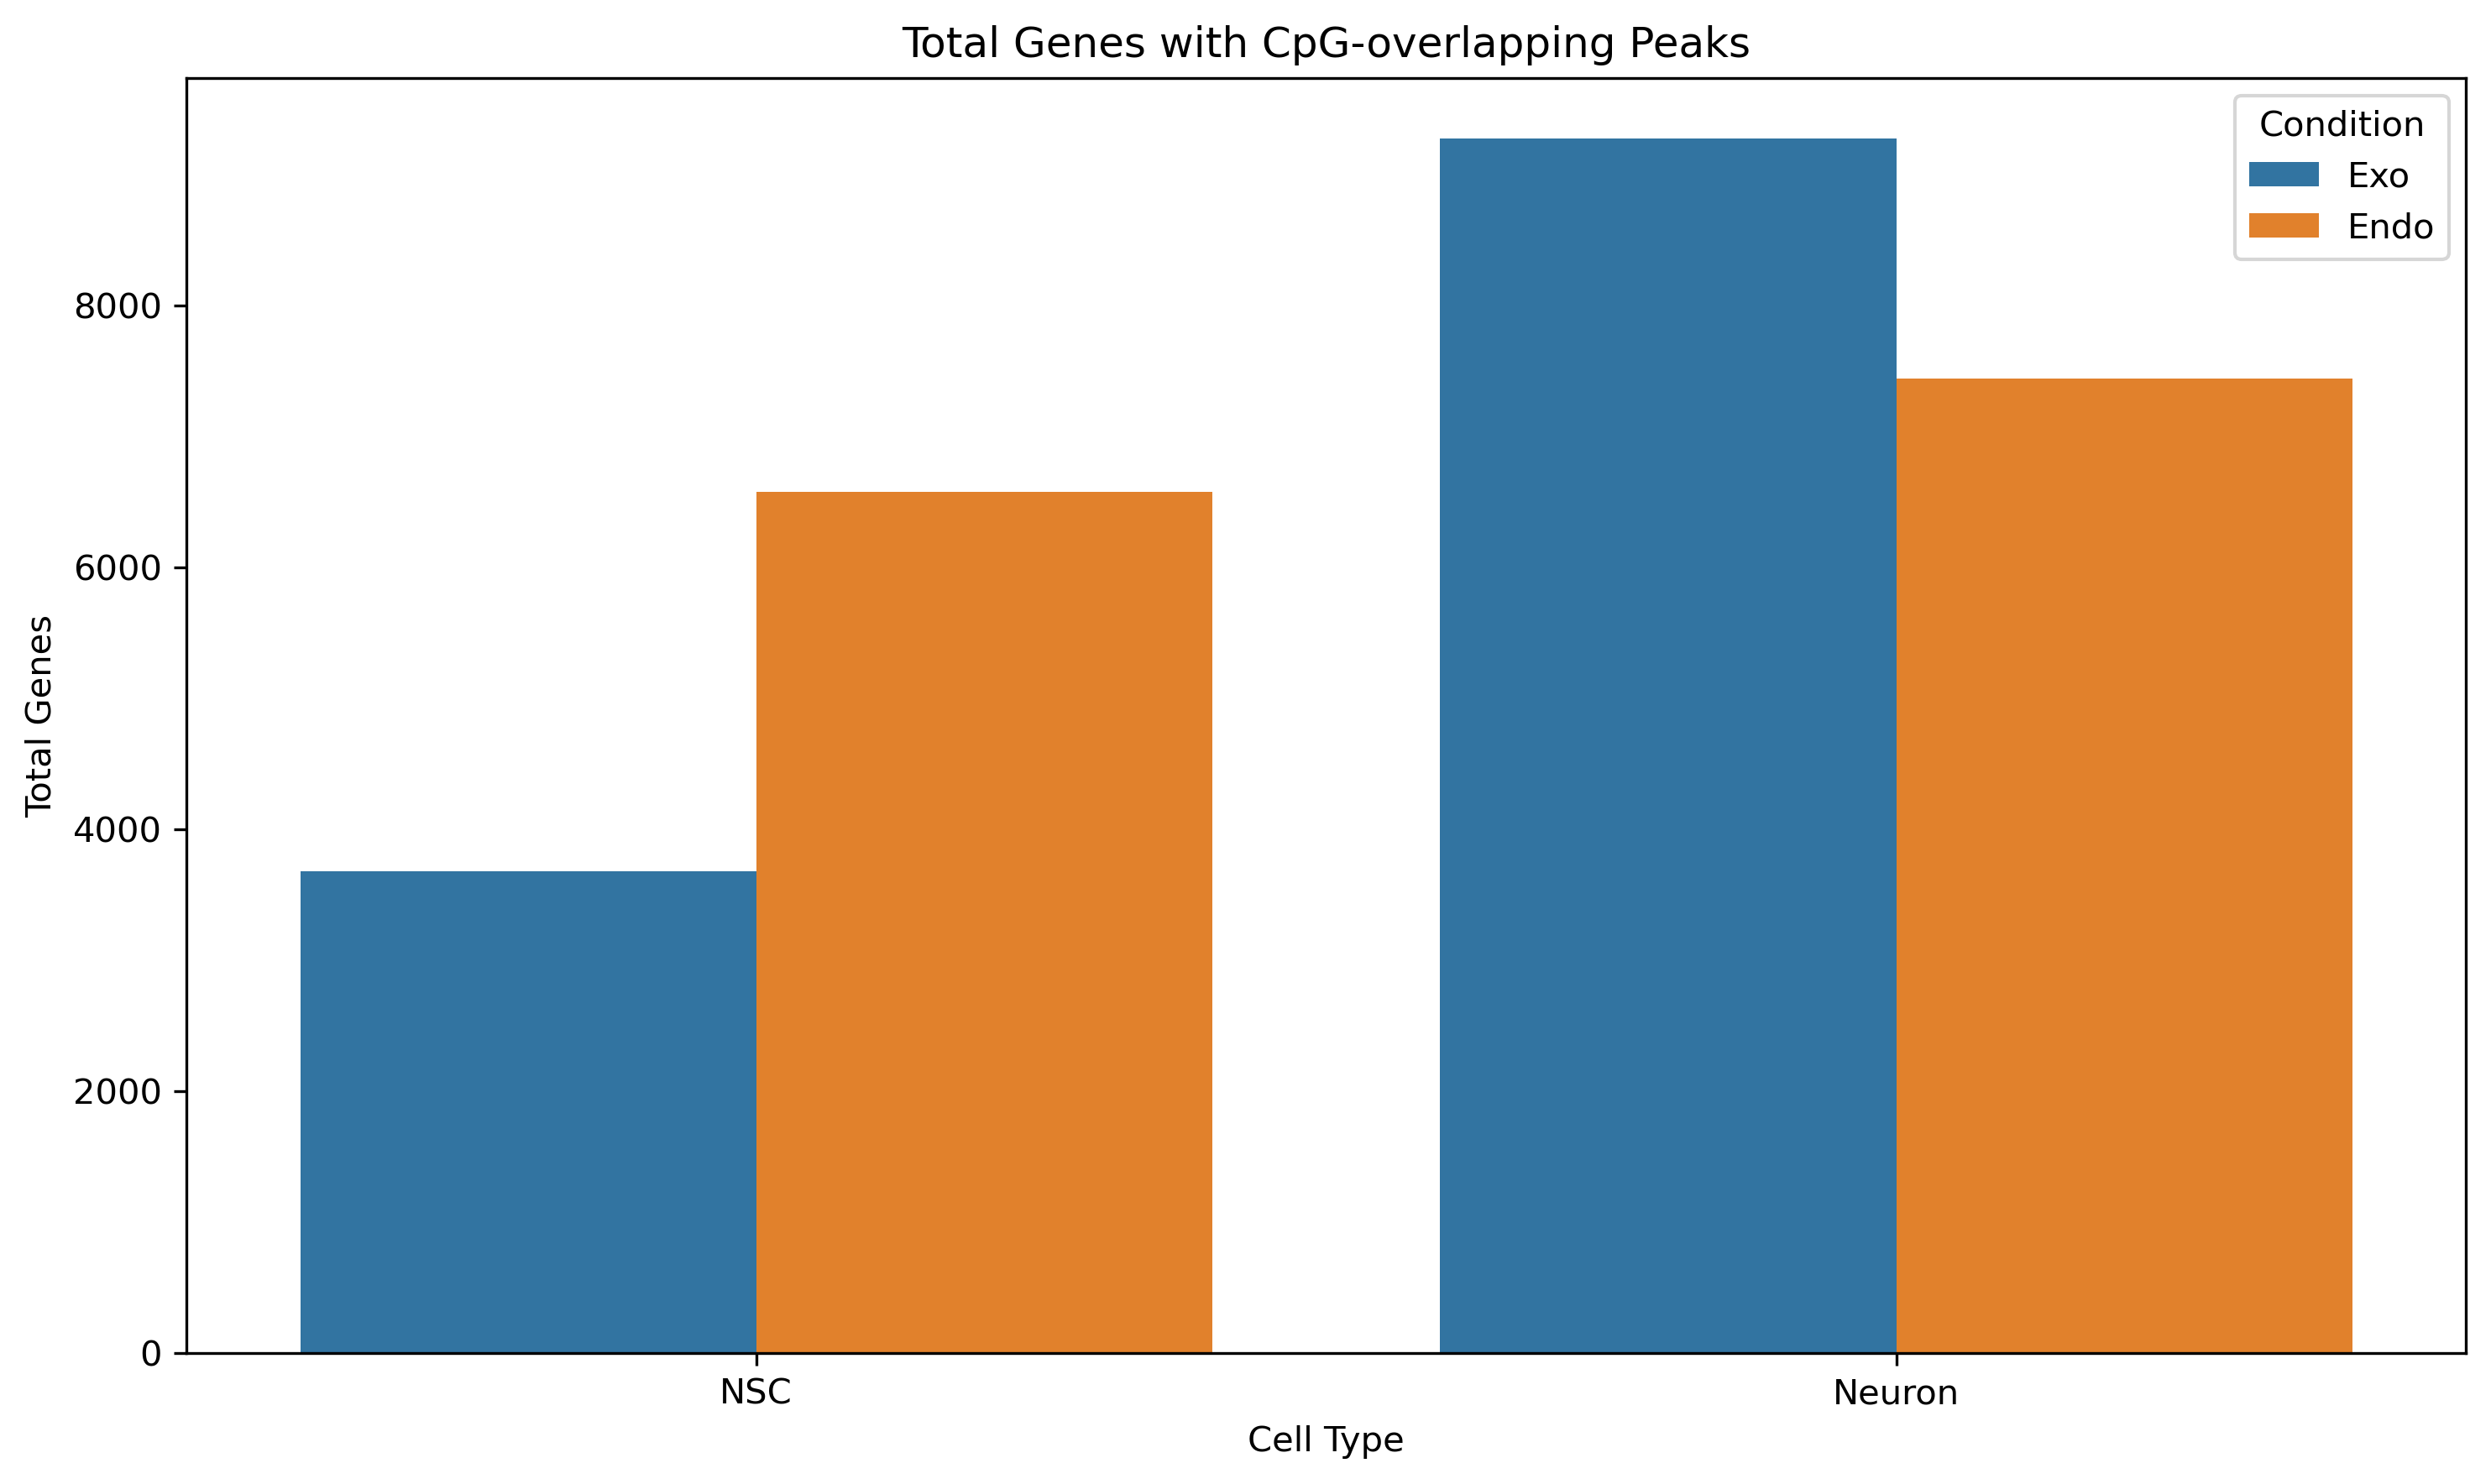


distance_distribution.png:


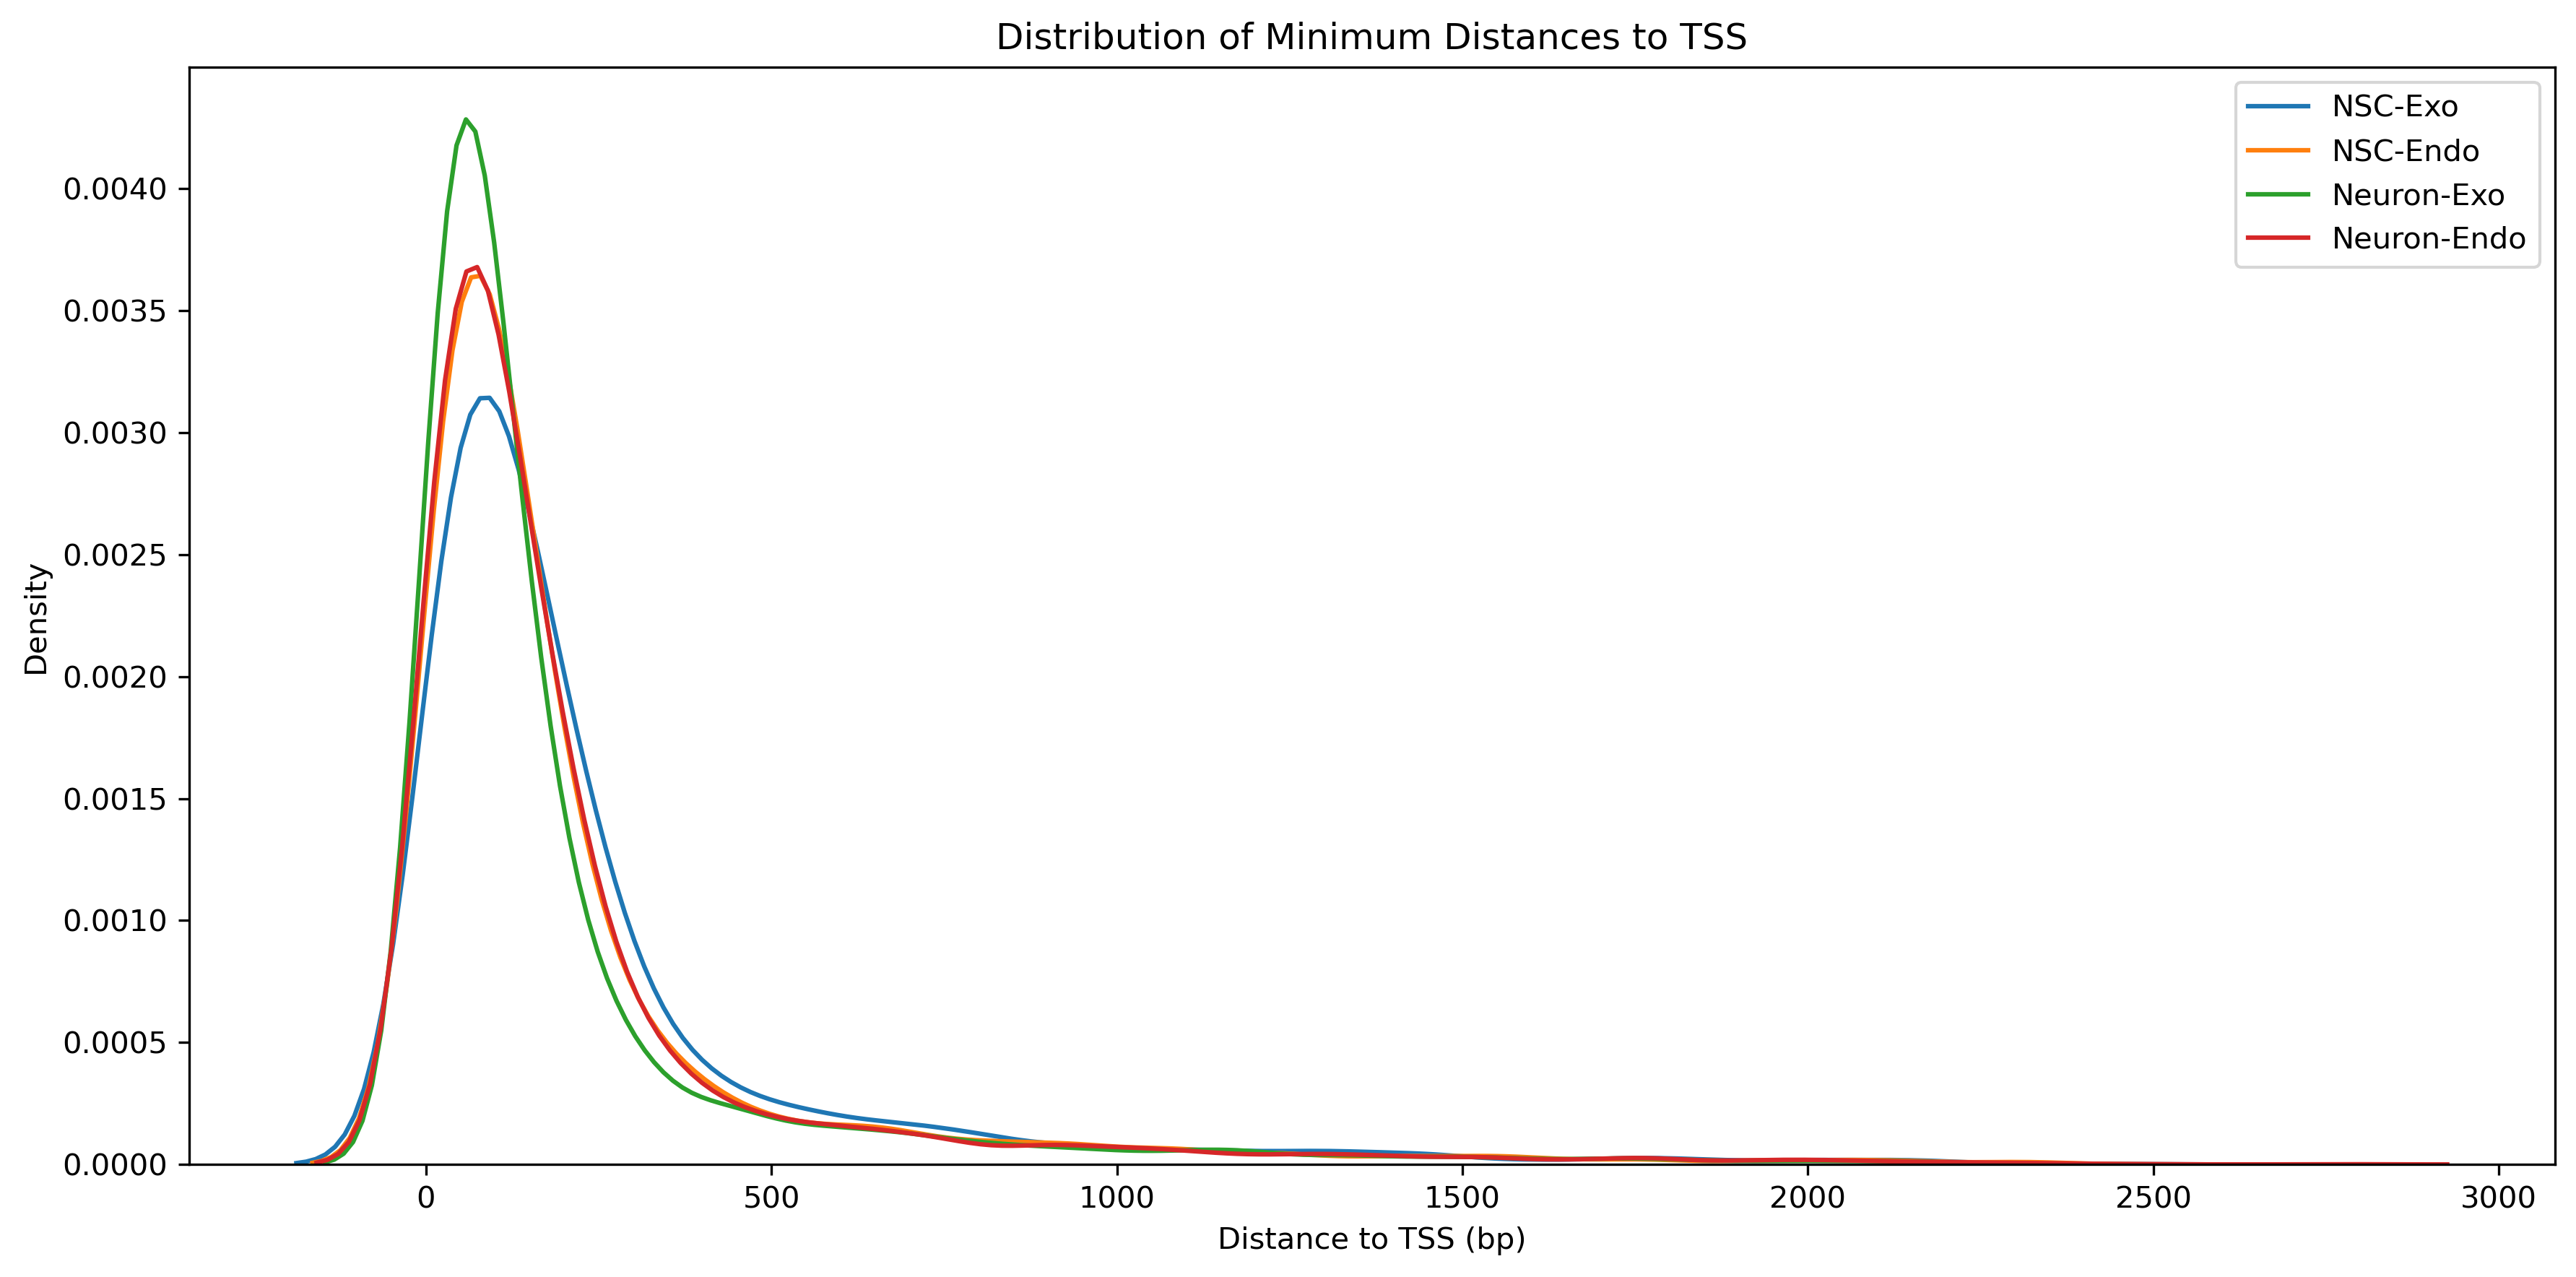


NSC_Exo_top_genes_heatmap.png:


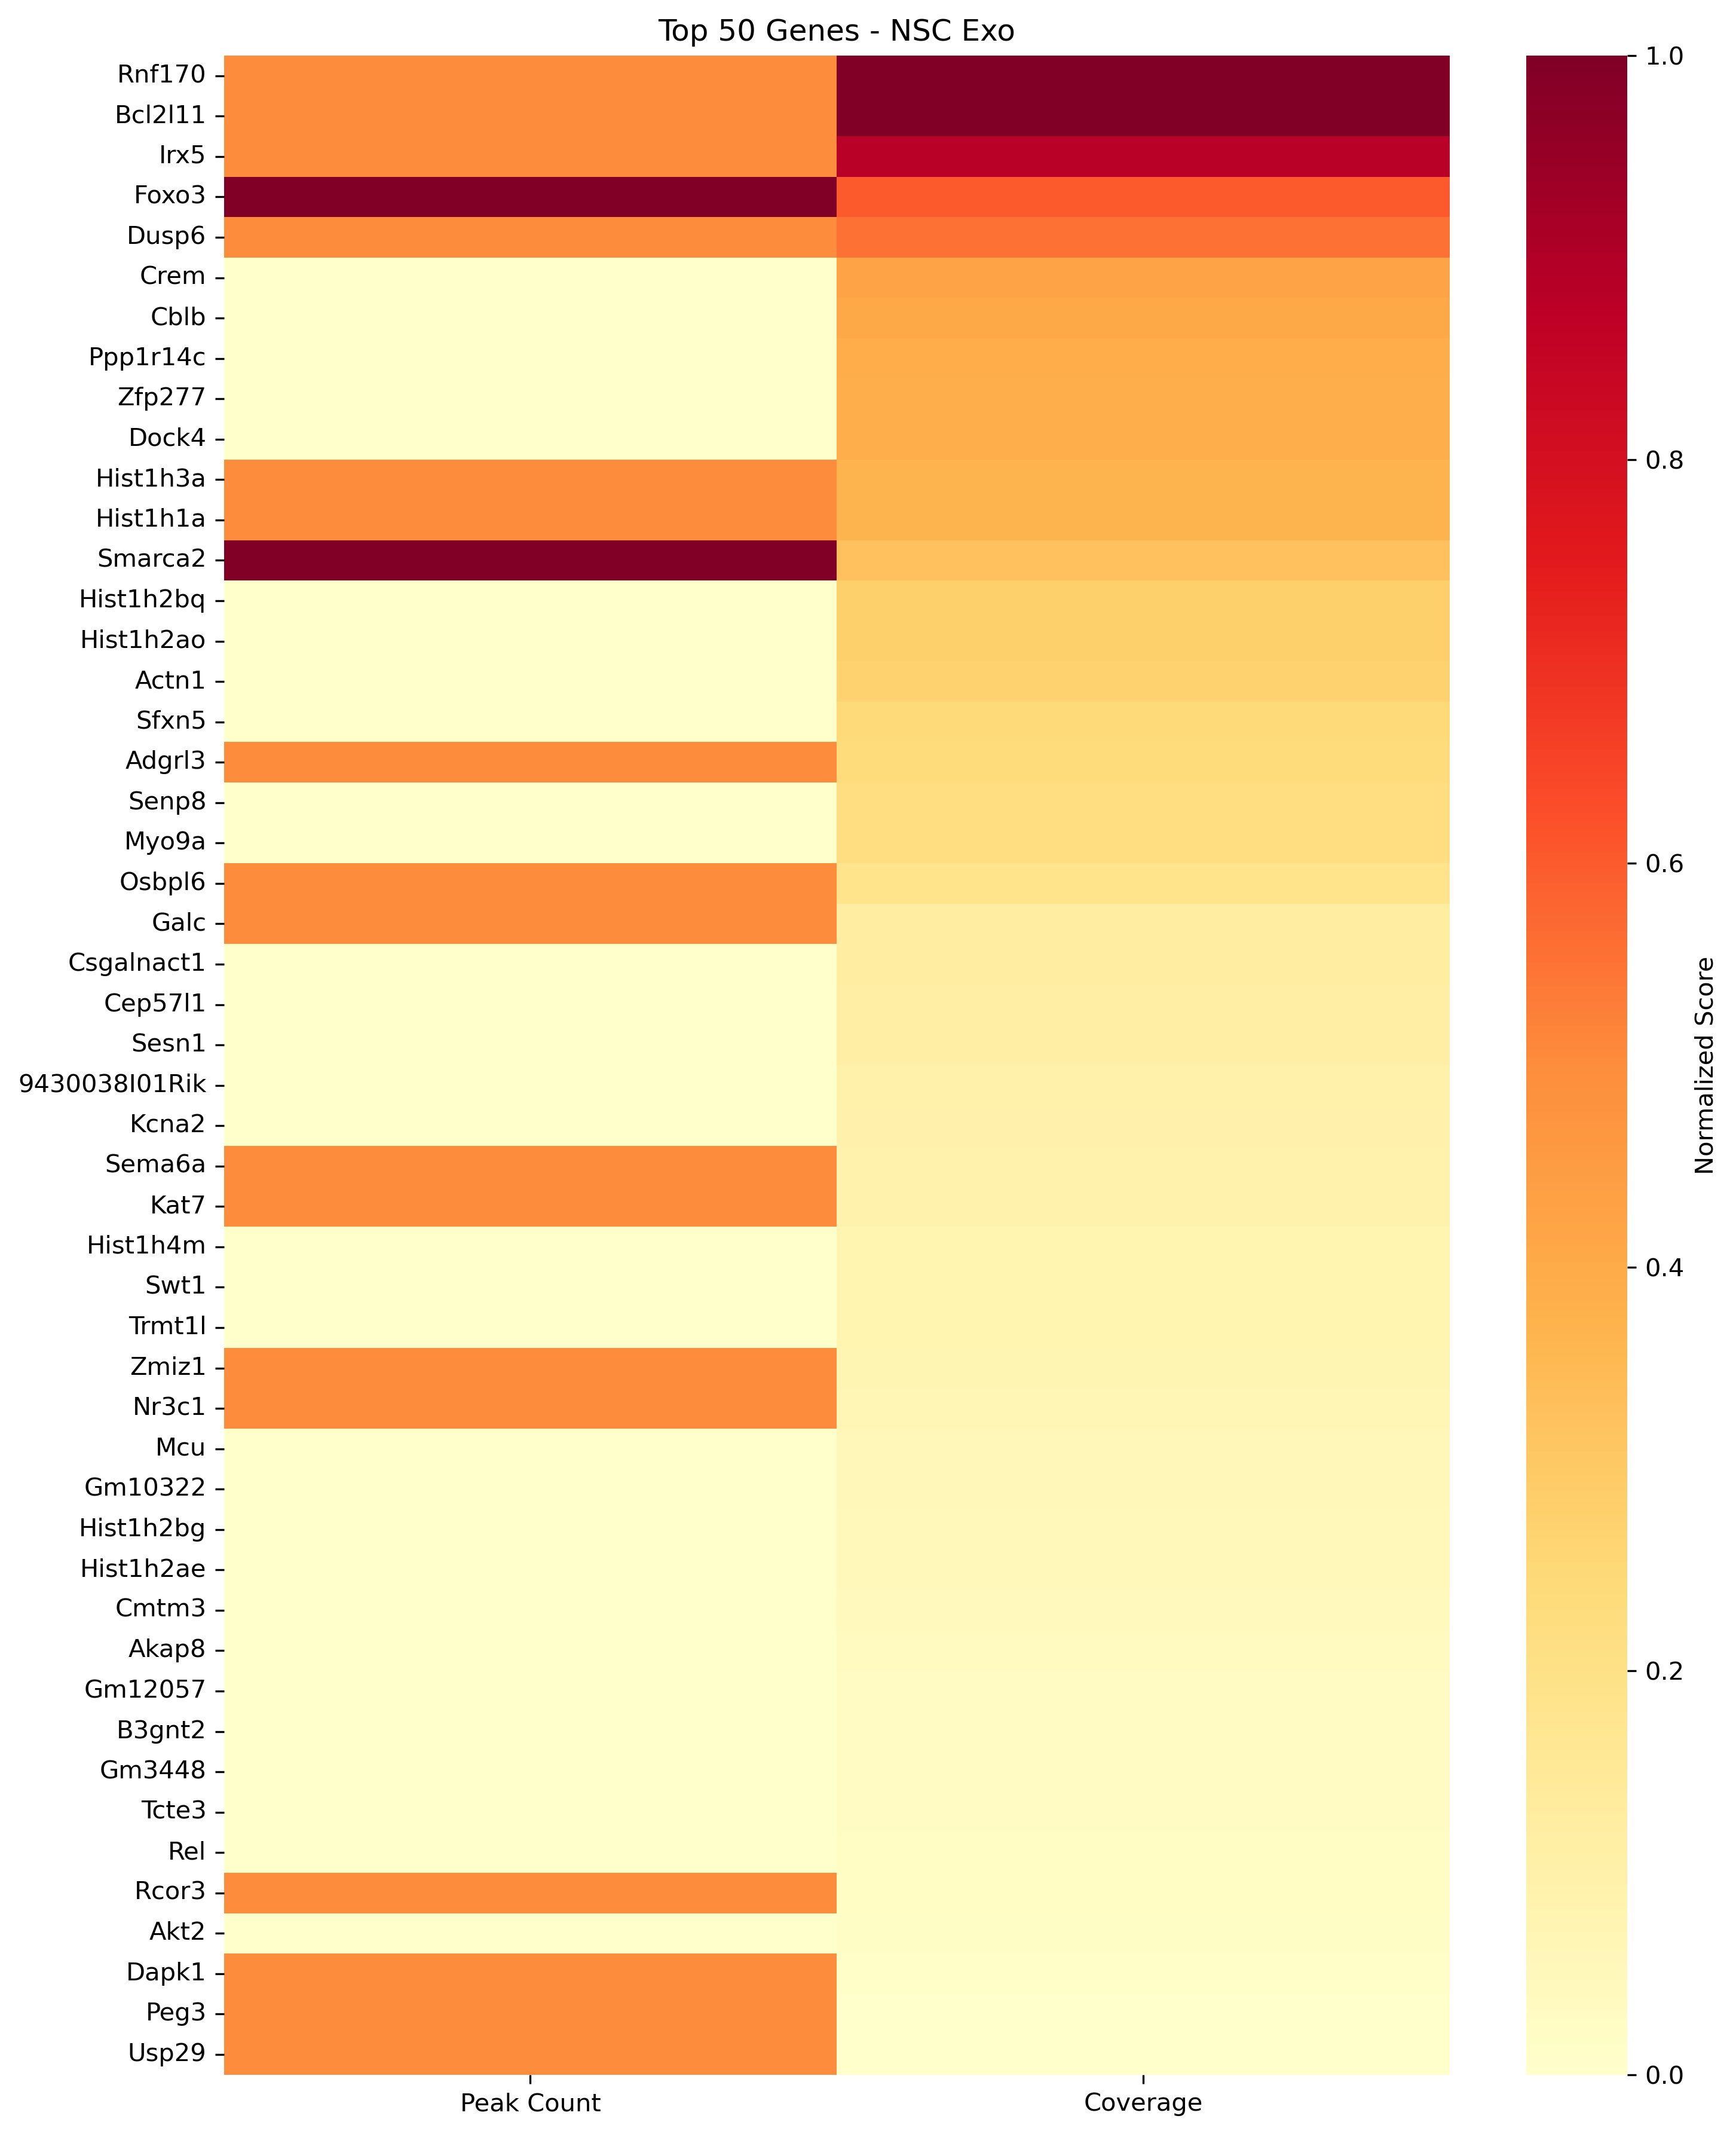


Neuron_venn.png:


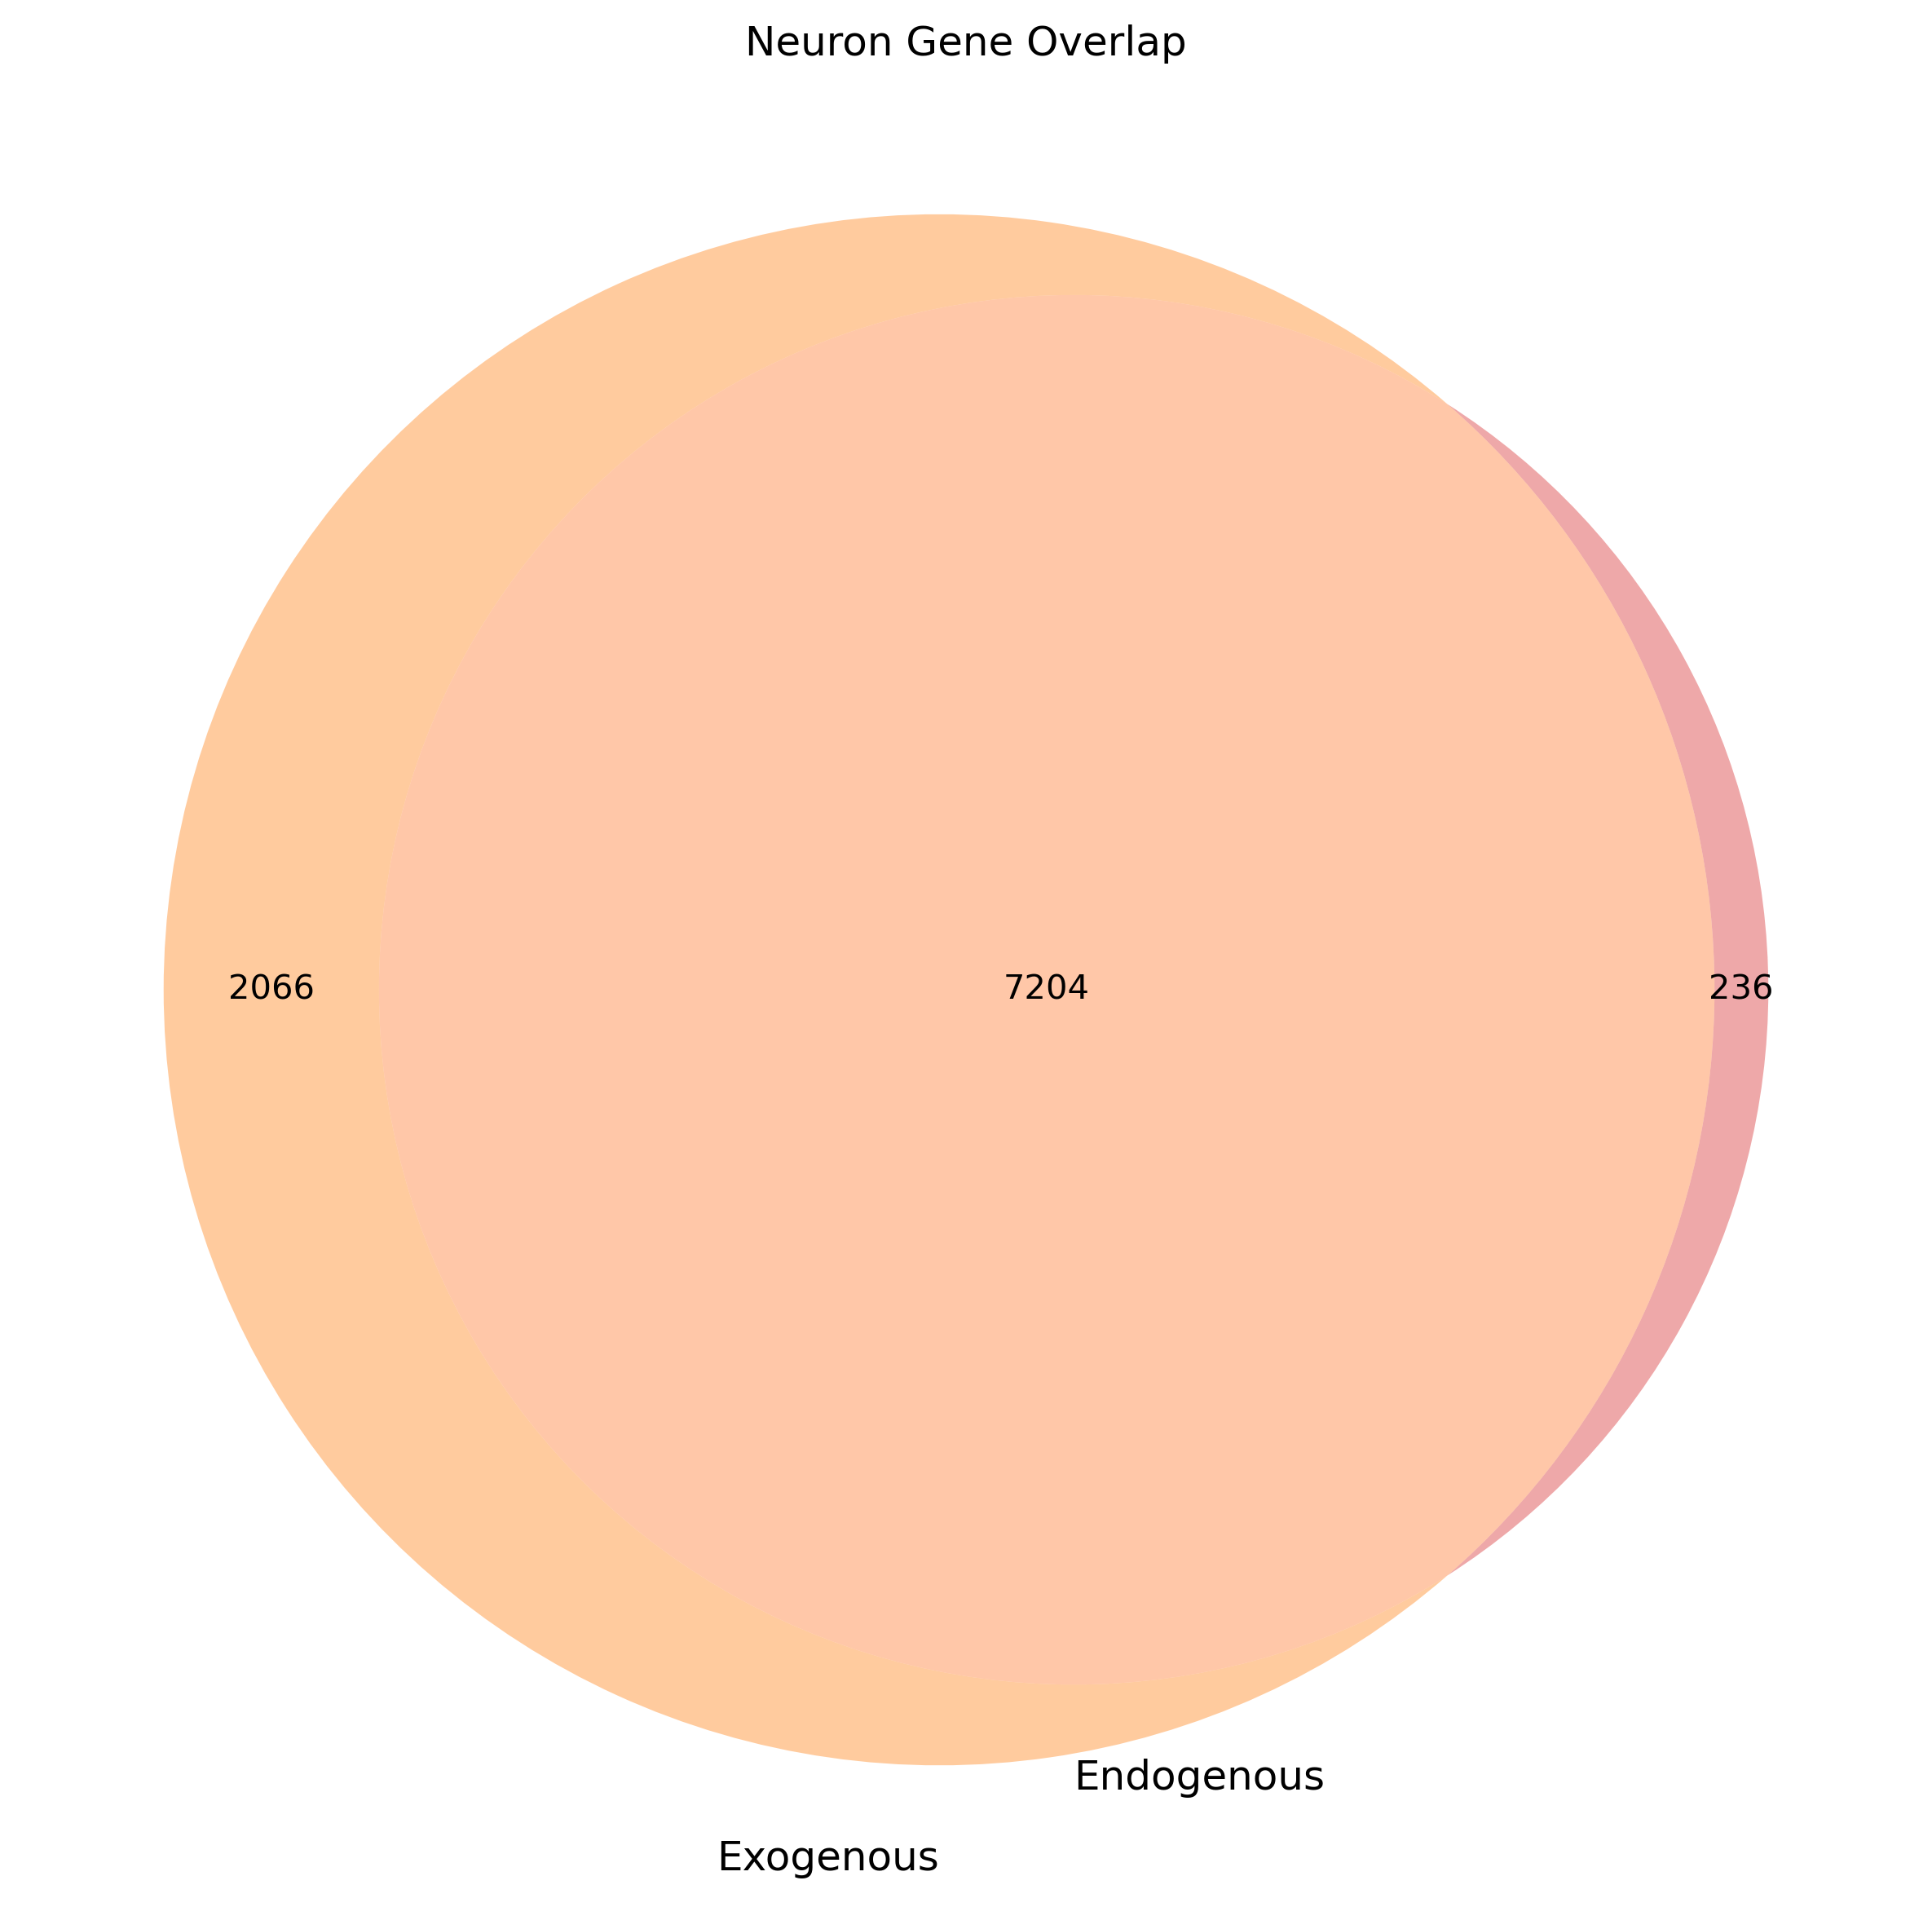


NSC_Endo_top_genes_heatmap.png:


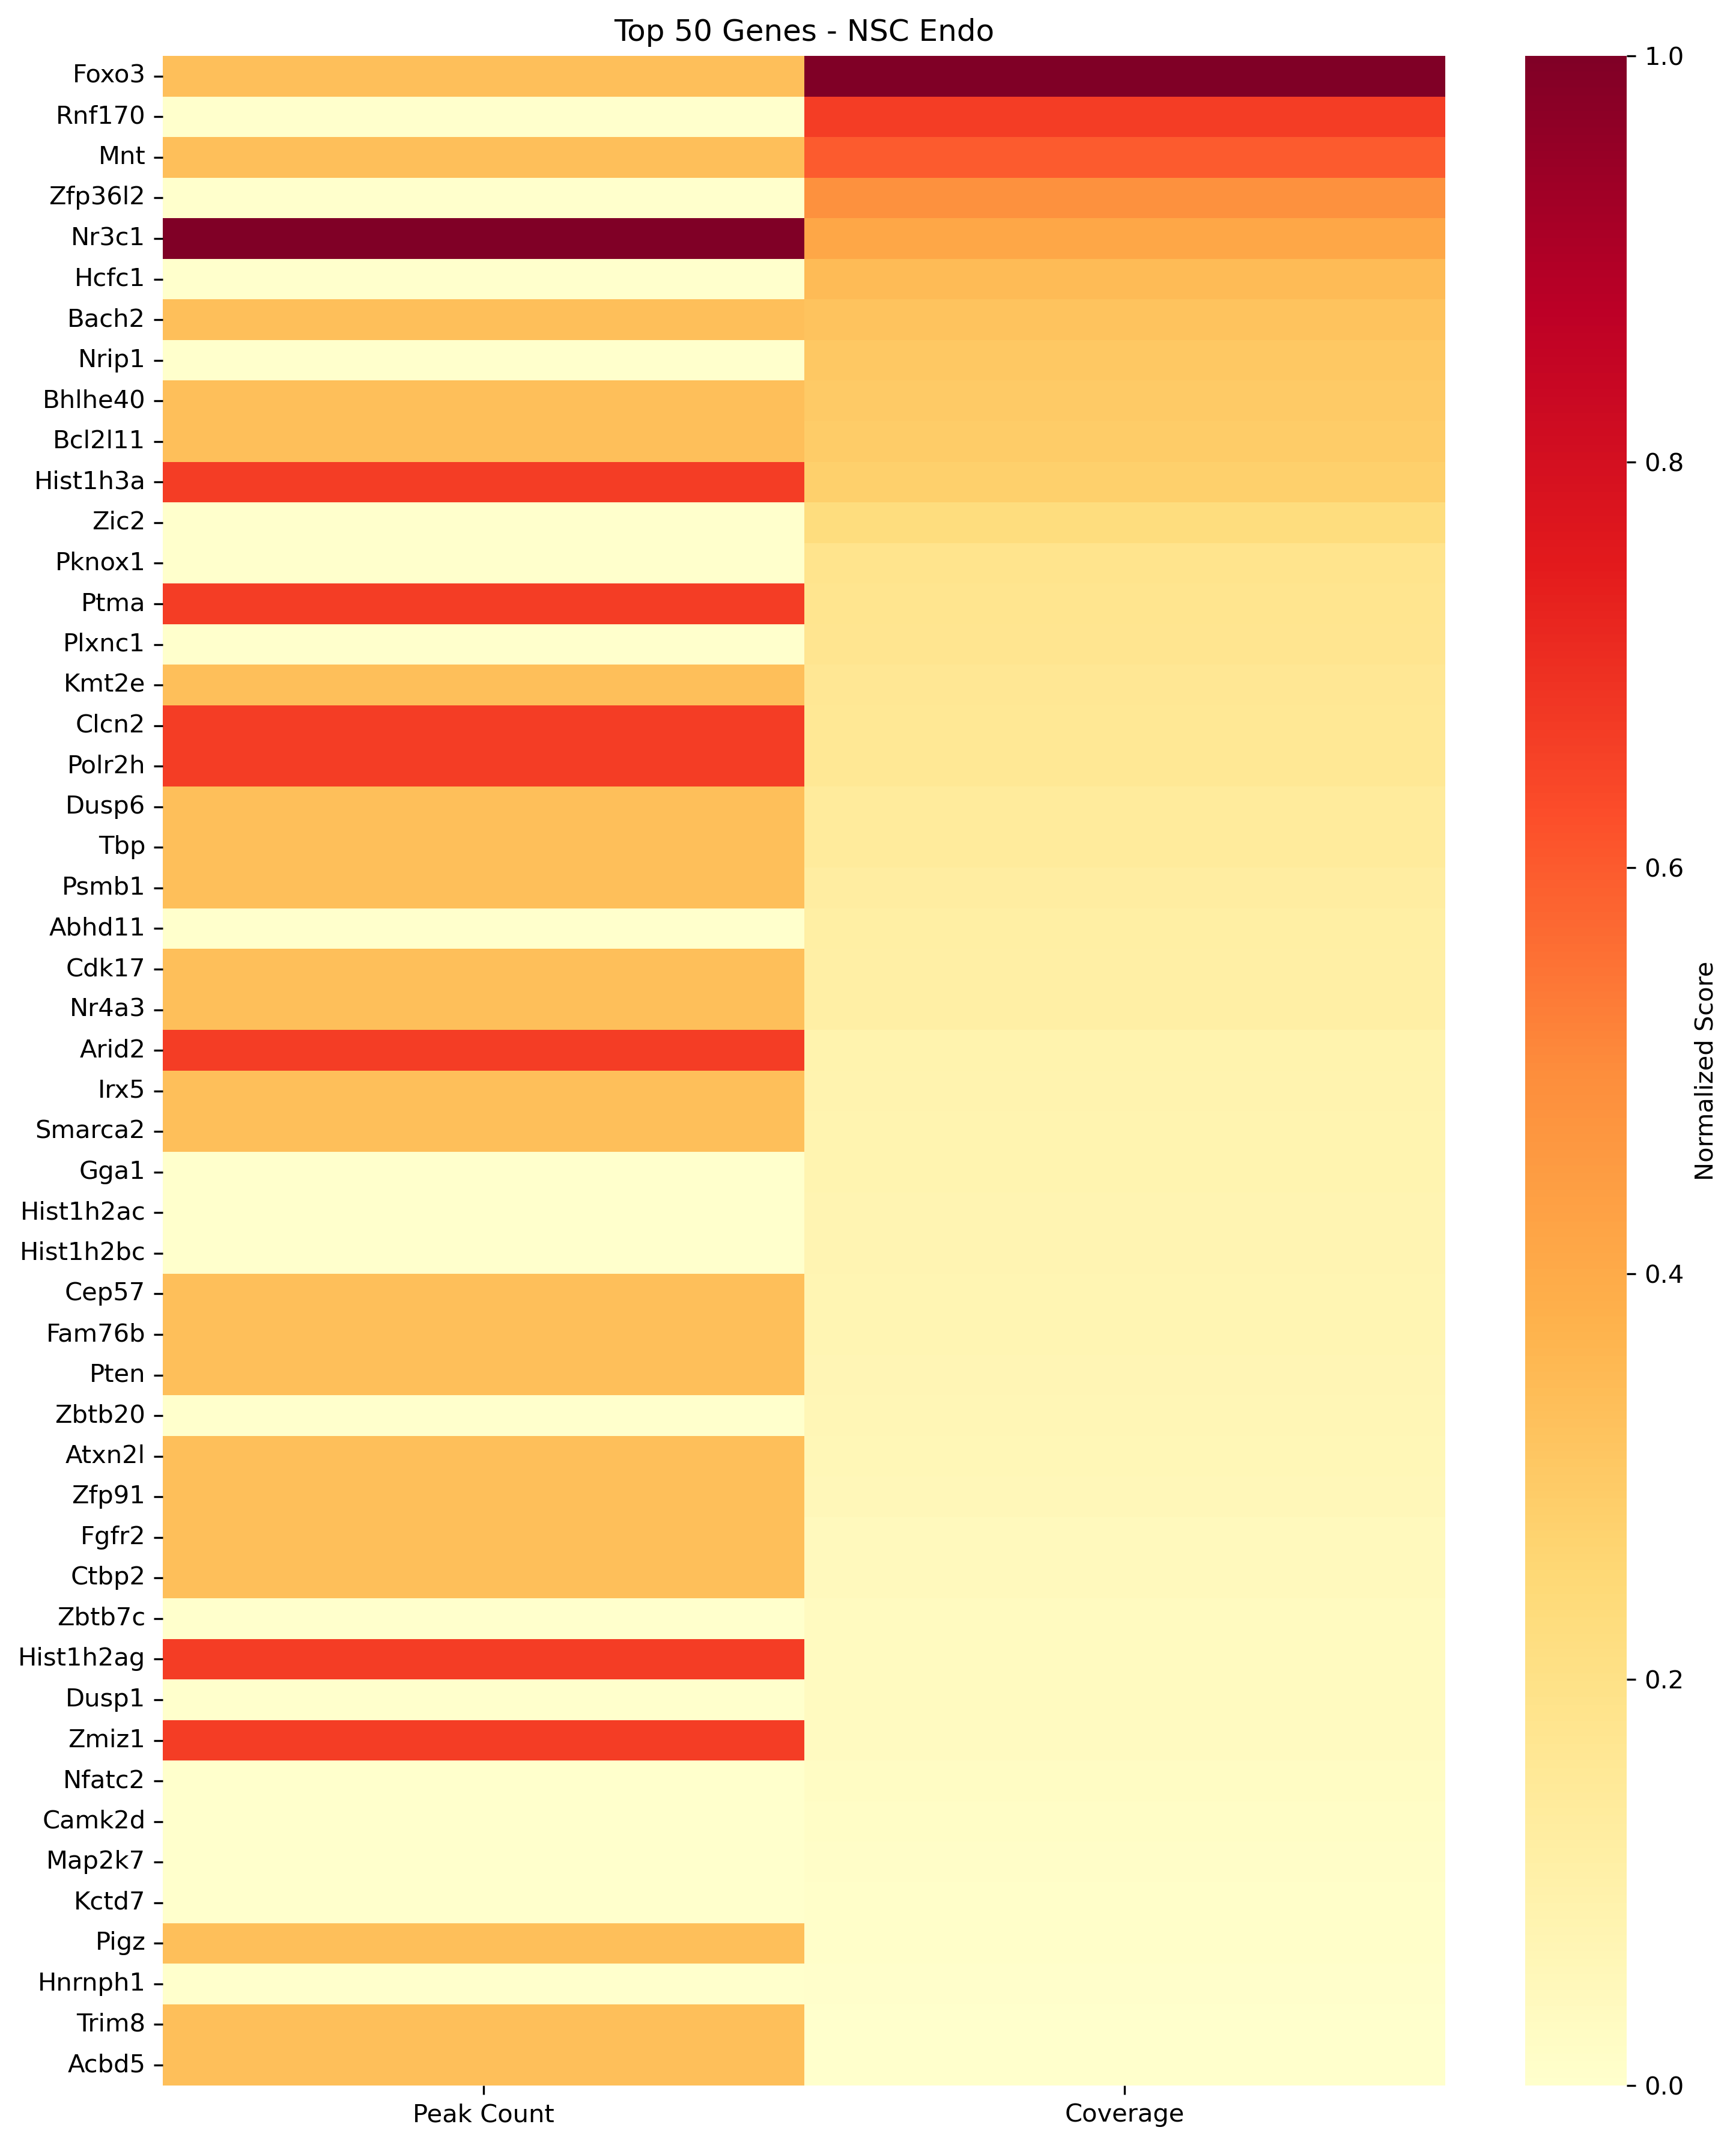


Neuron_Exo_top_genes_heatmap.png:


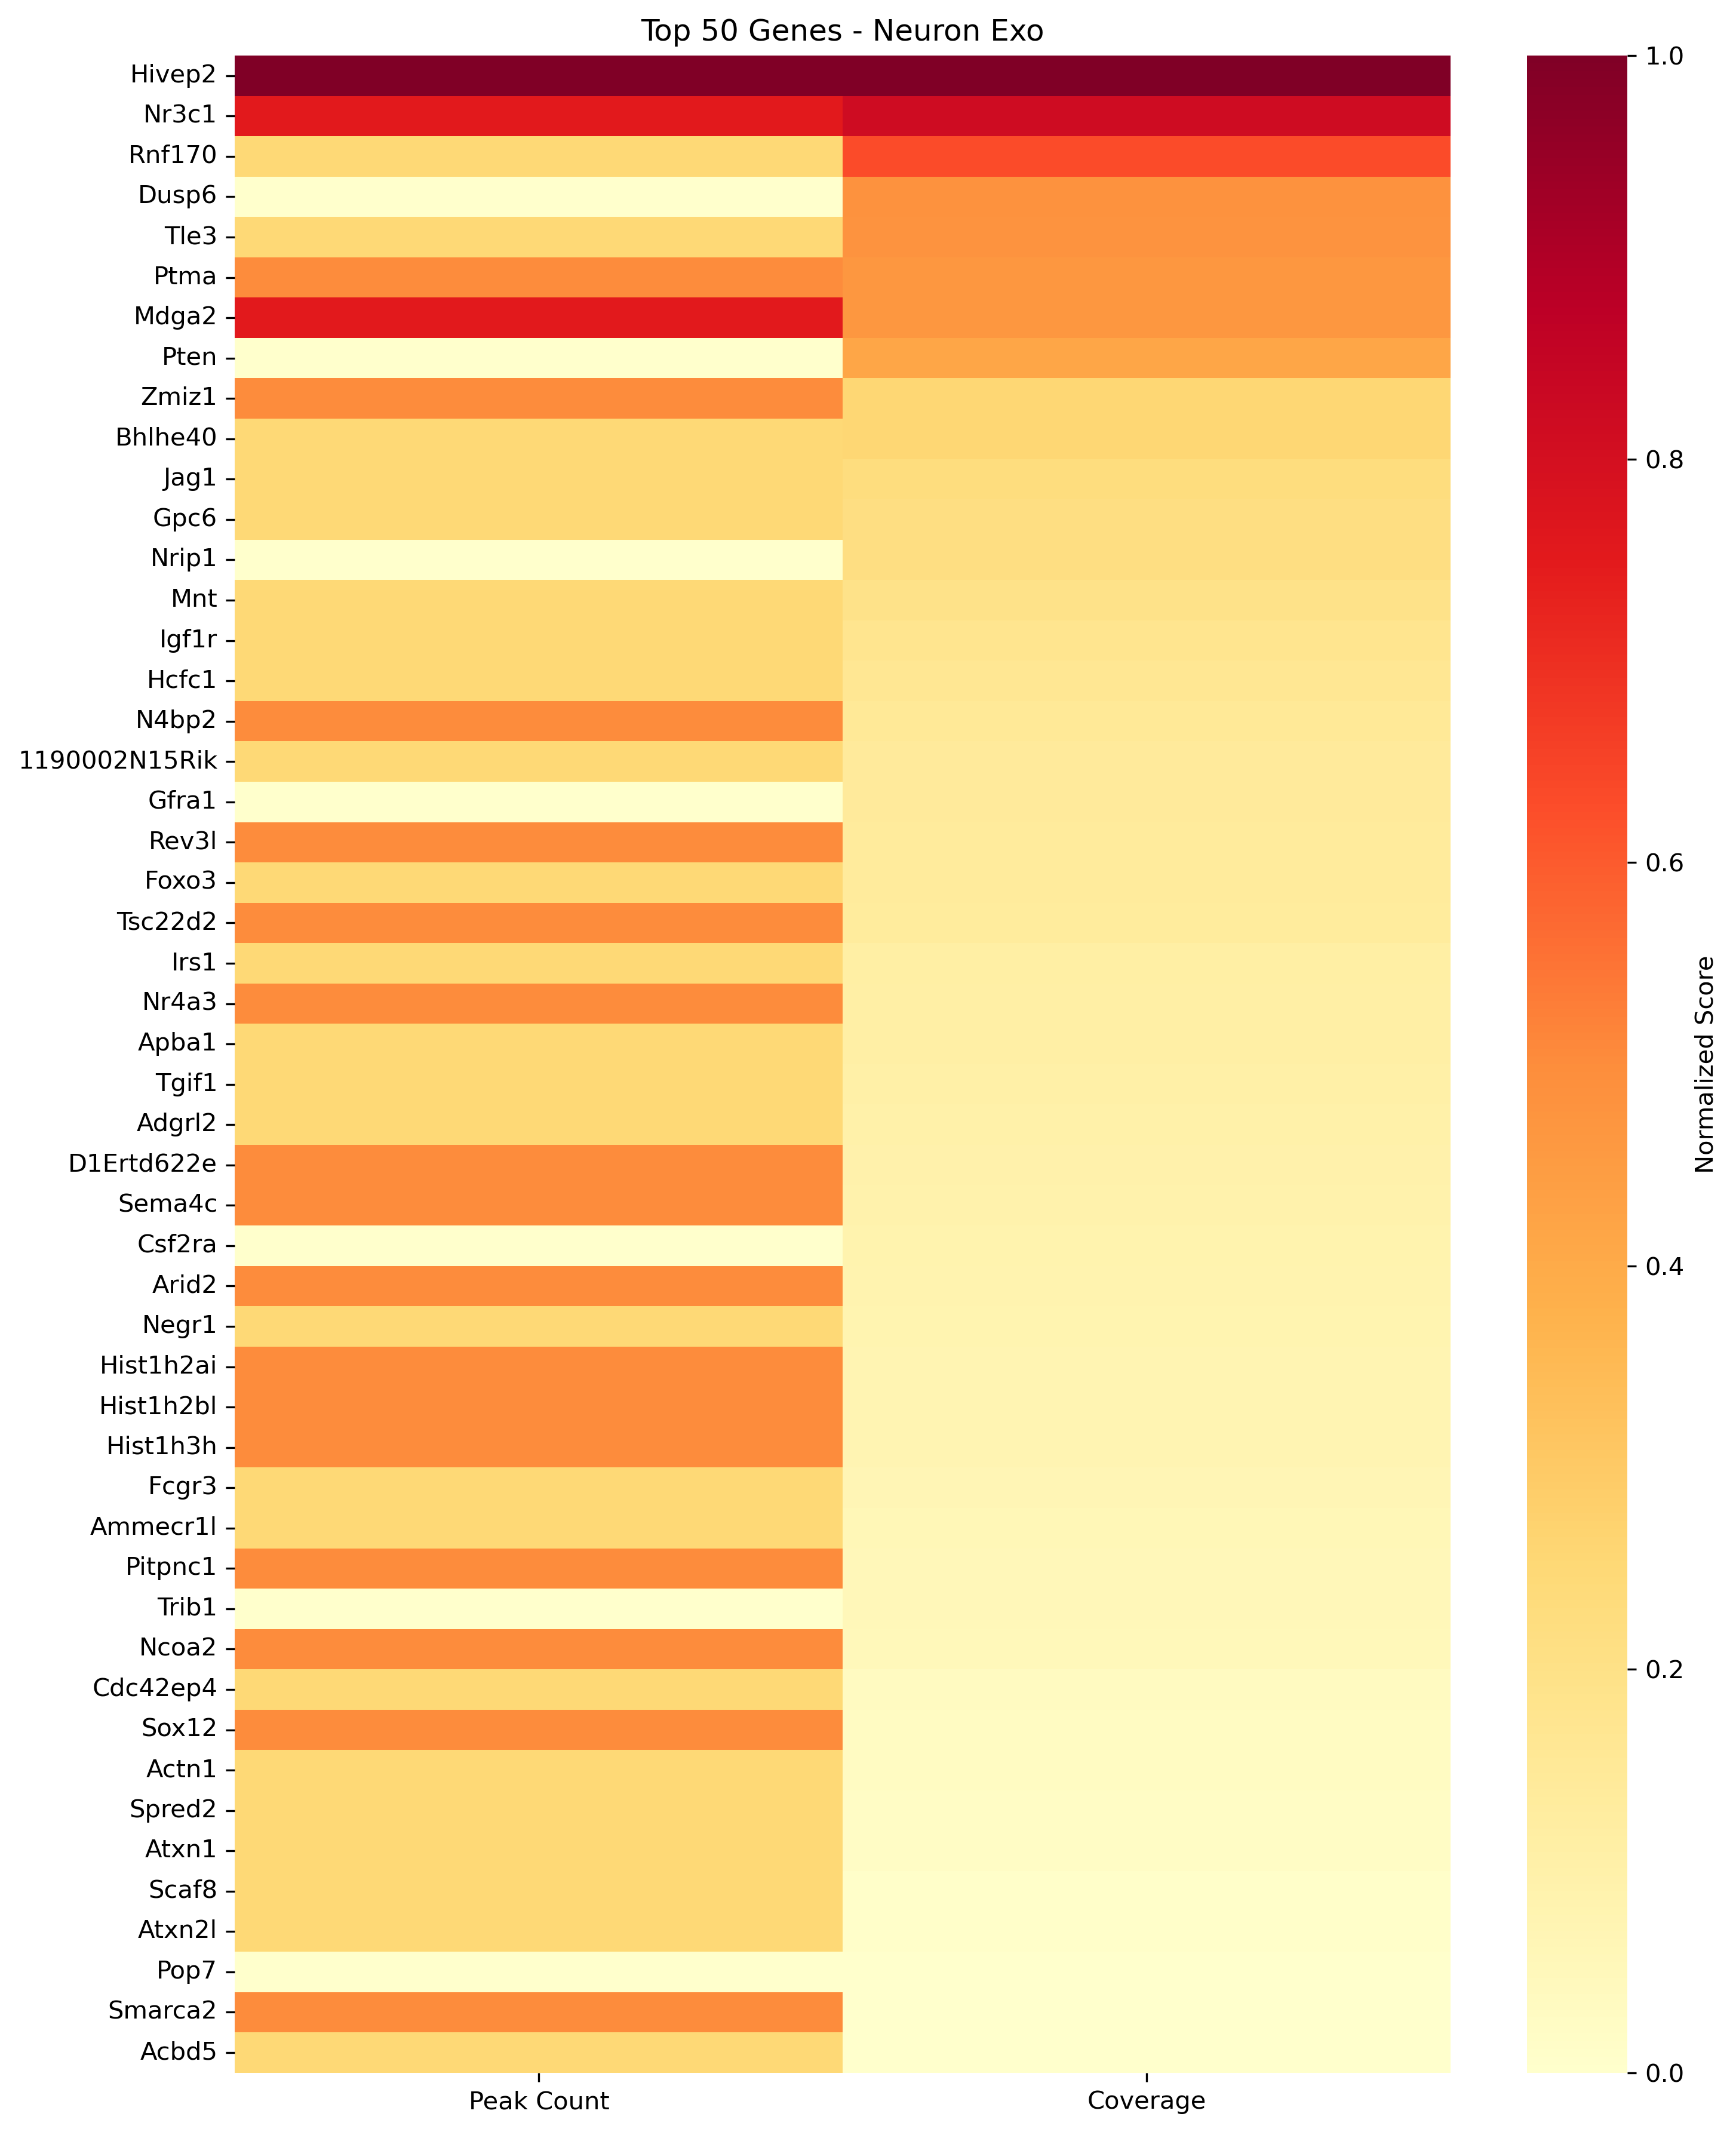


NSC_venn.png:


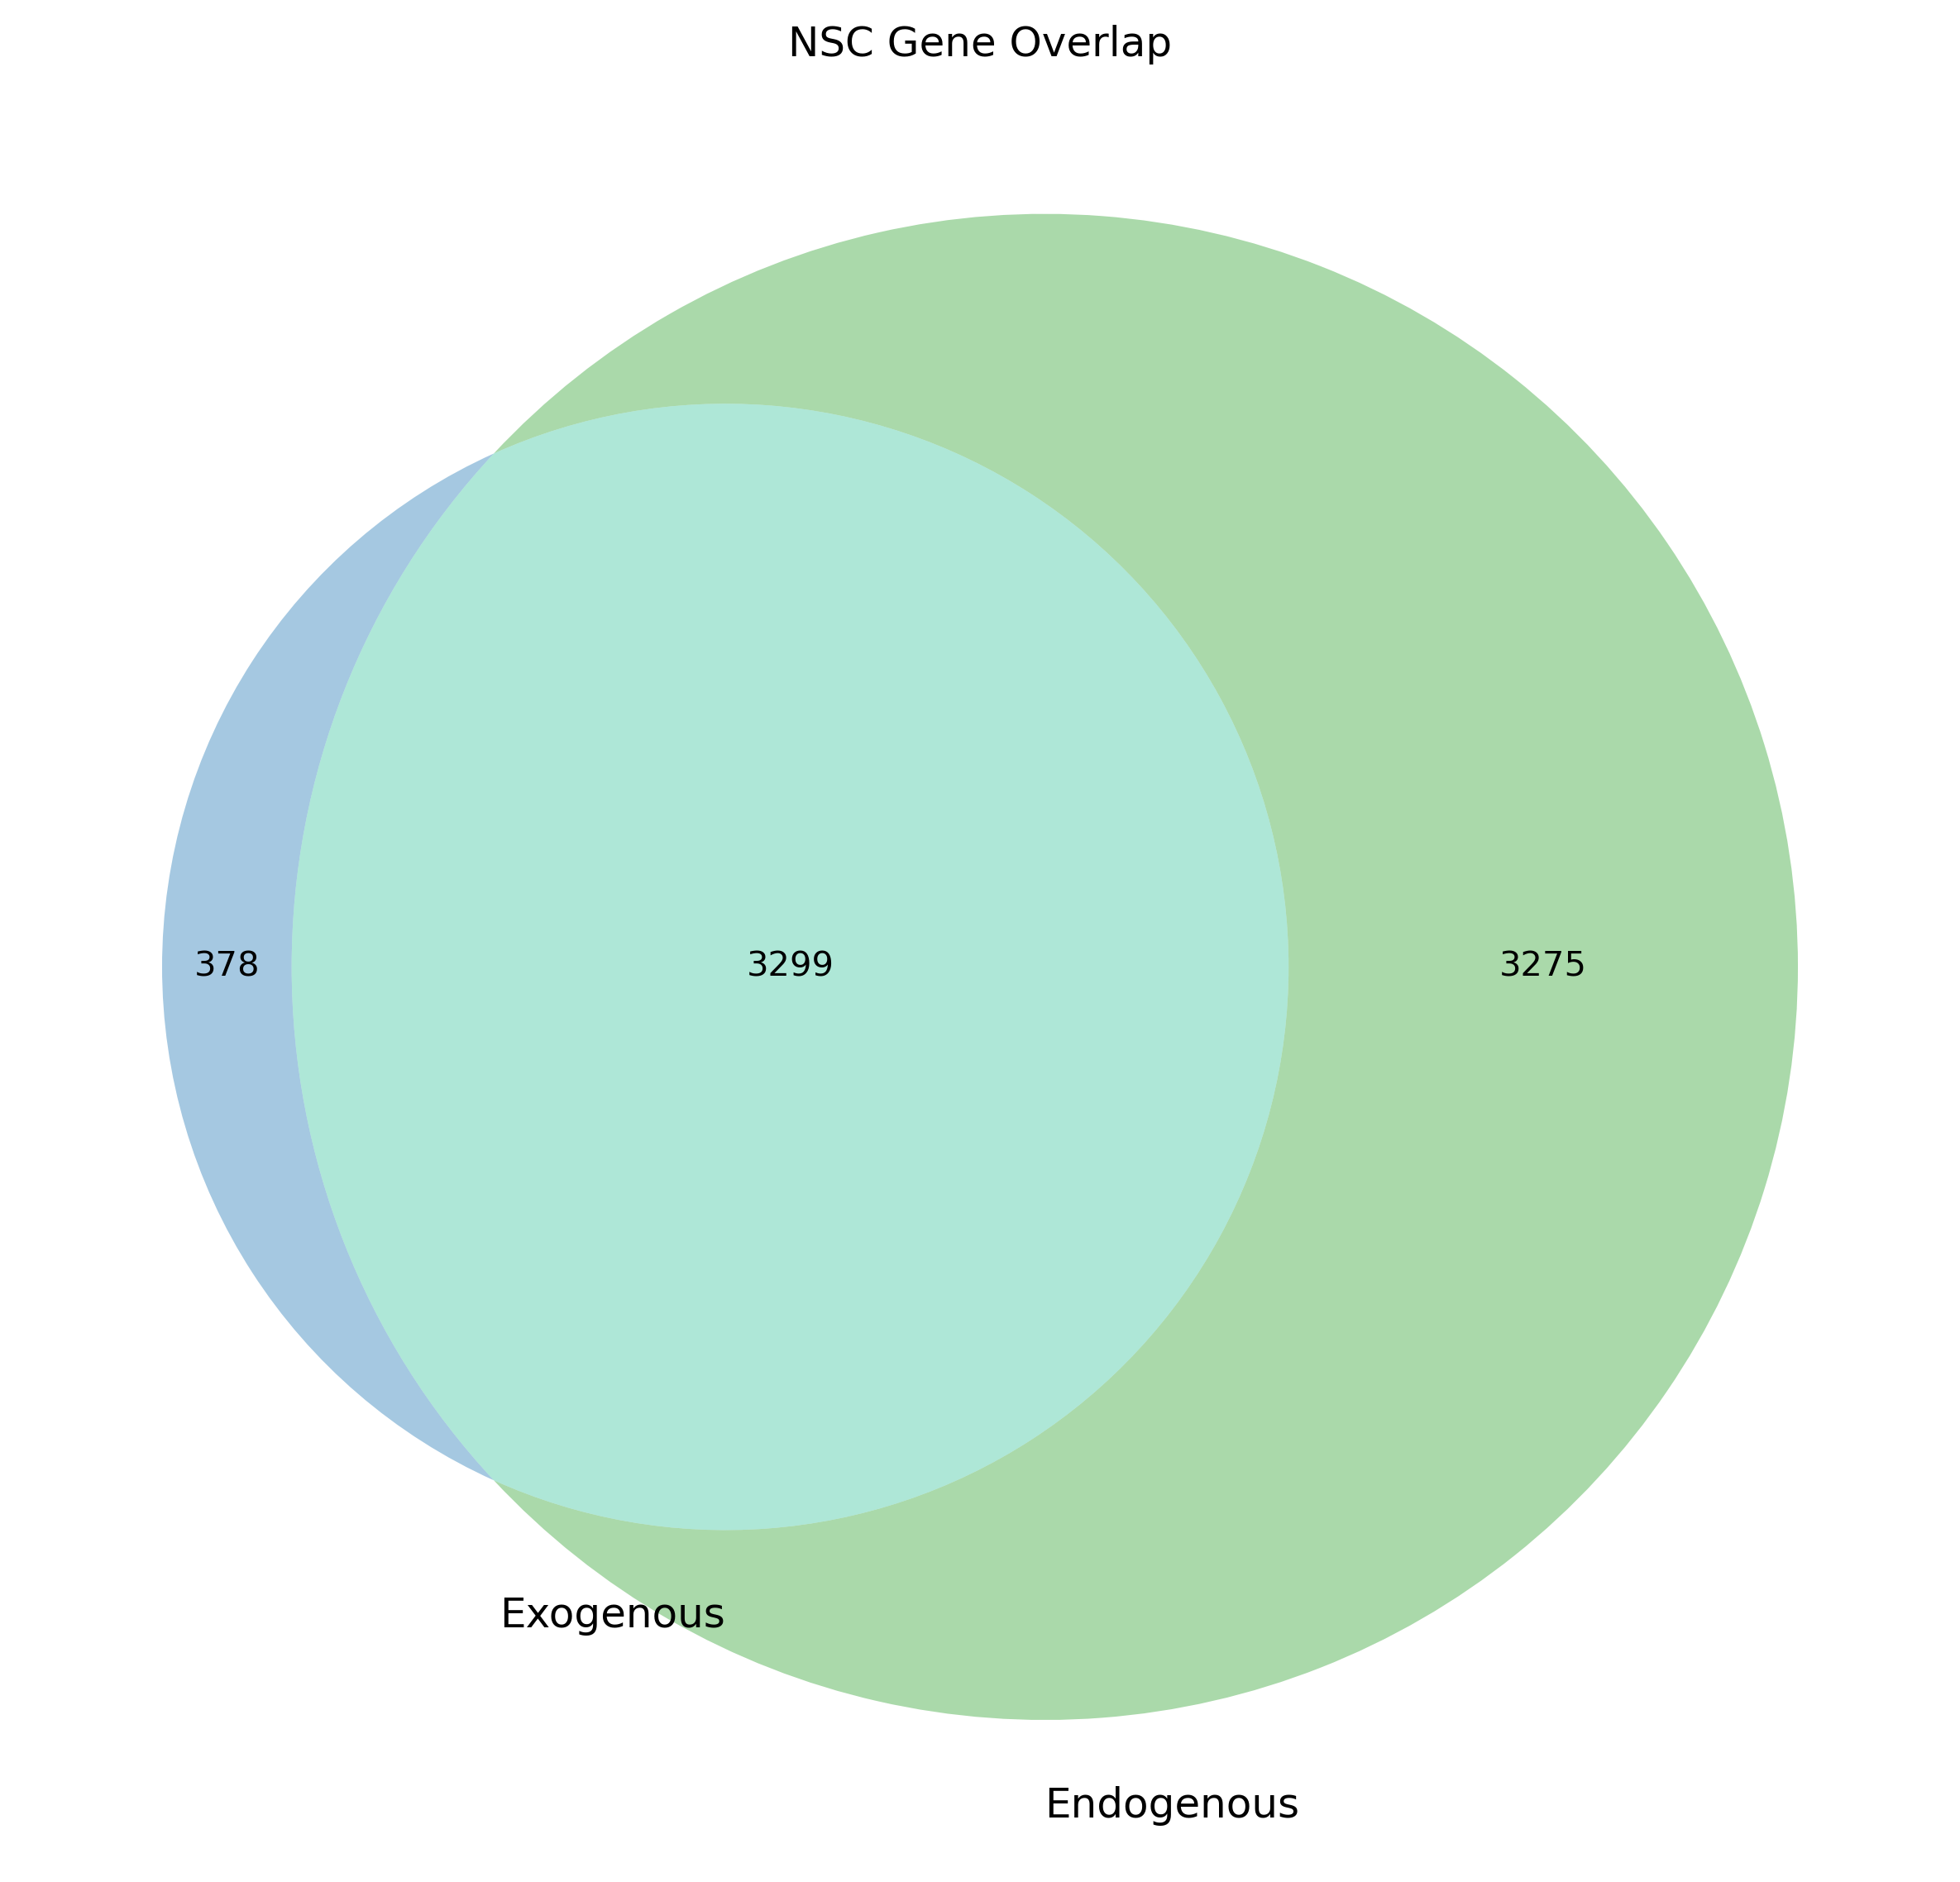


Neuron_Endo_top_genes_heatmap.png:


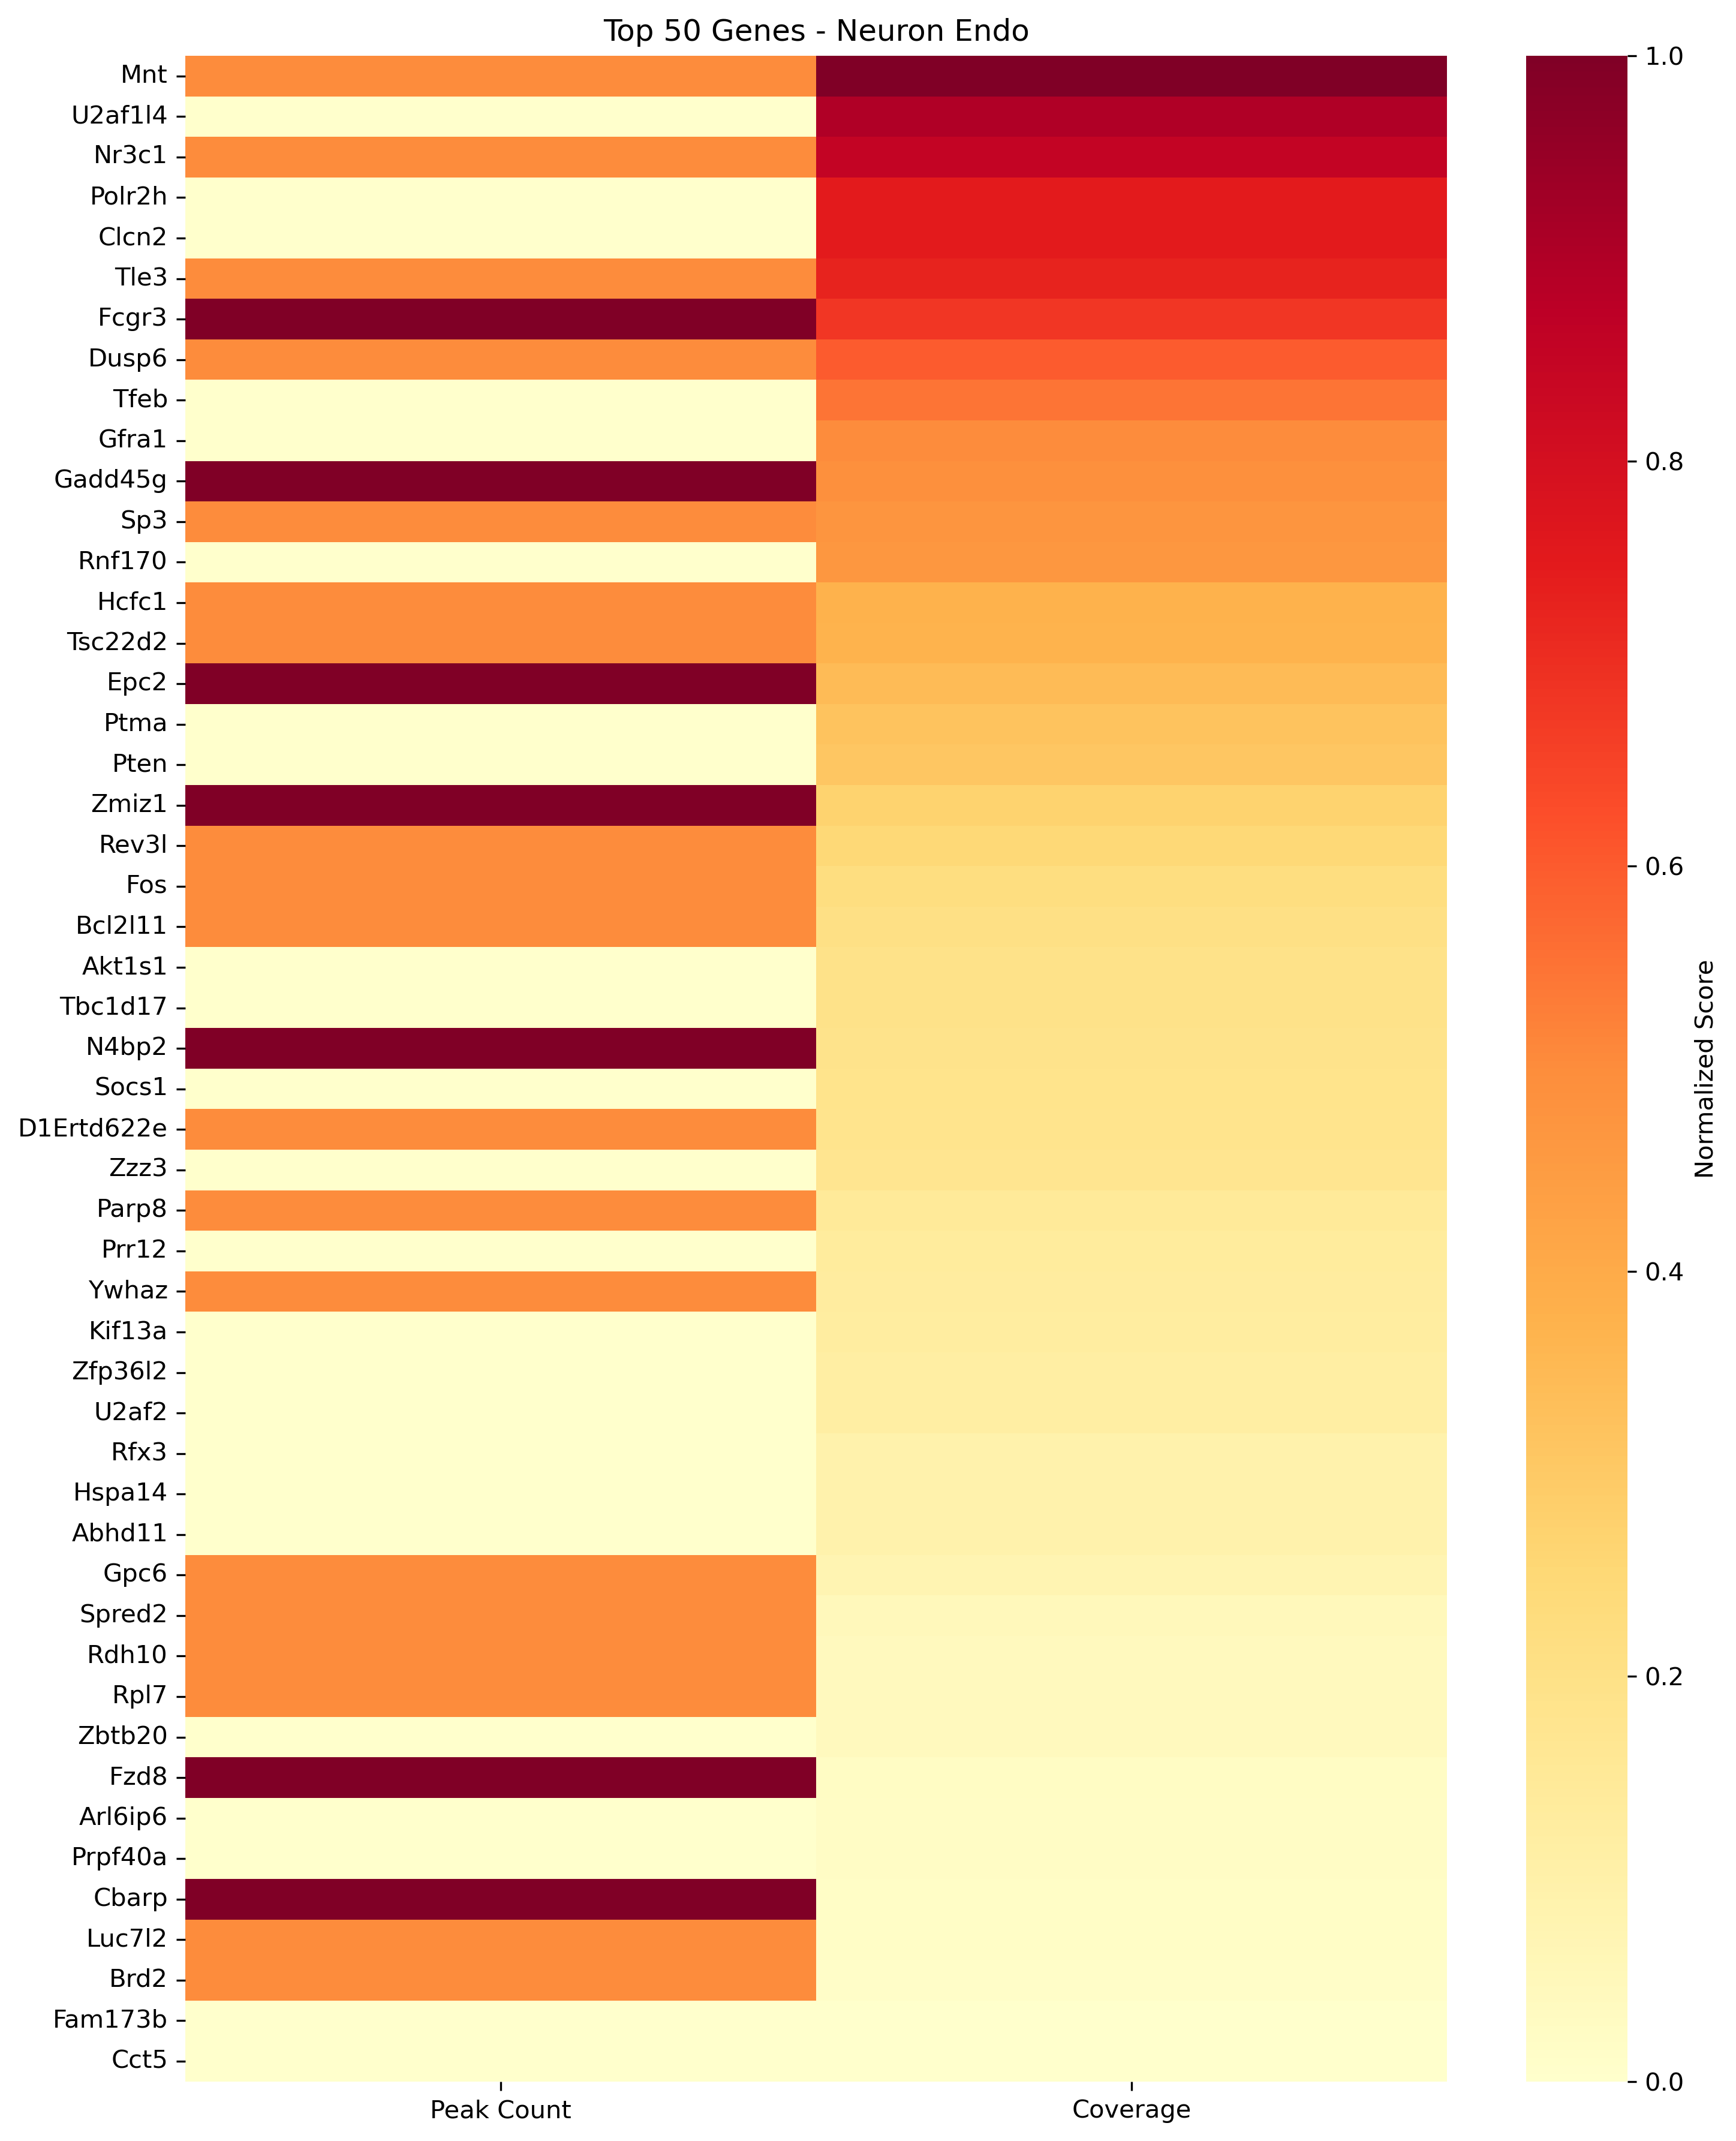


peak_distribution.png:


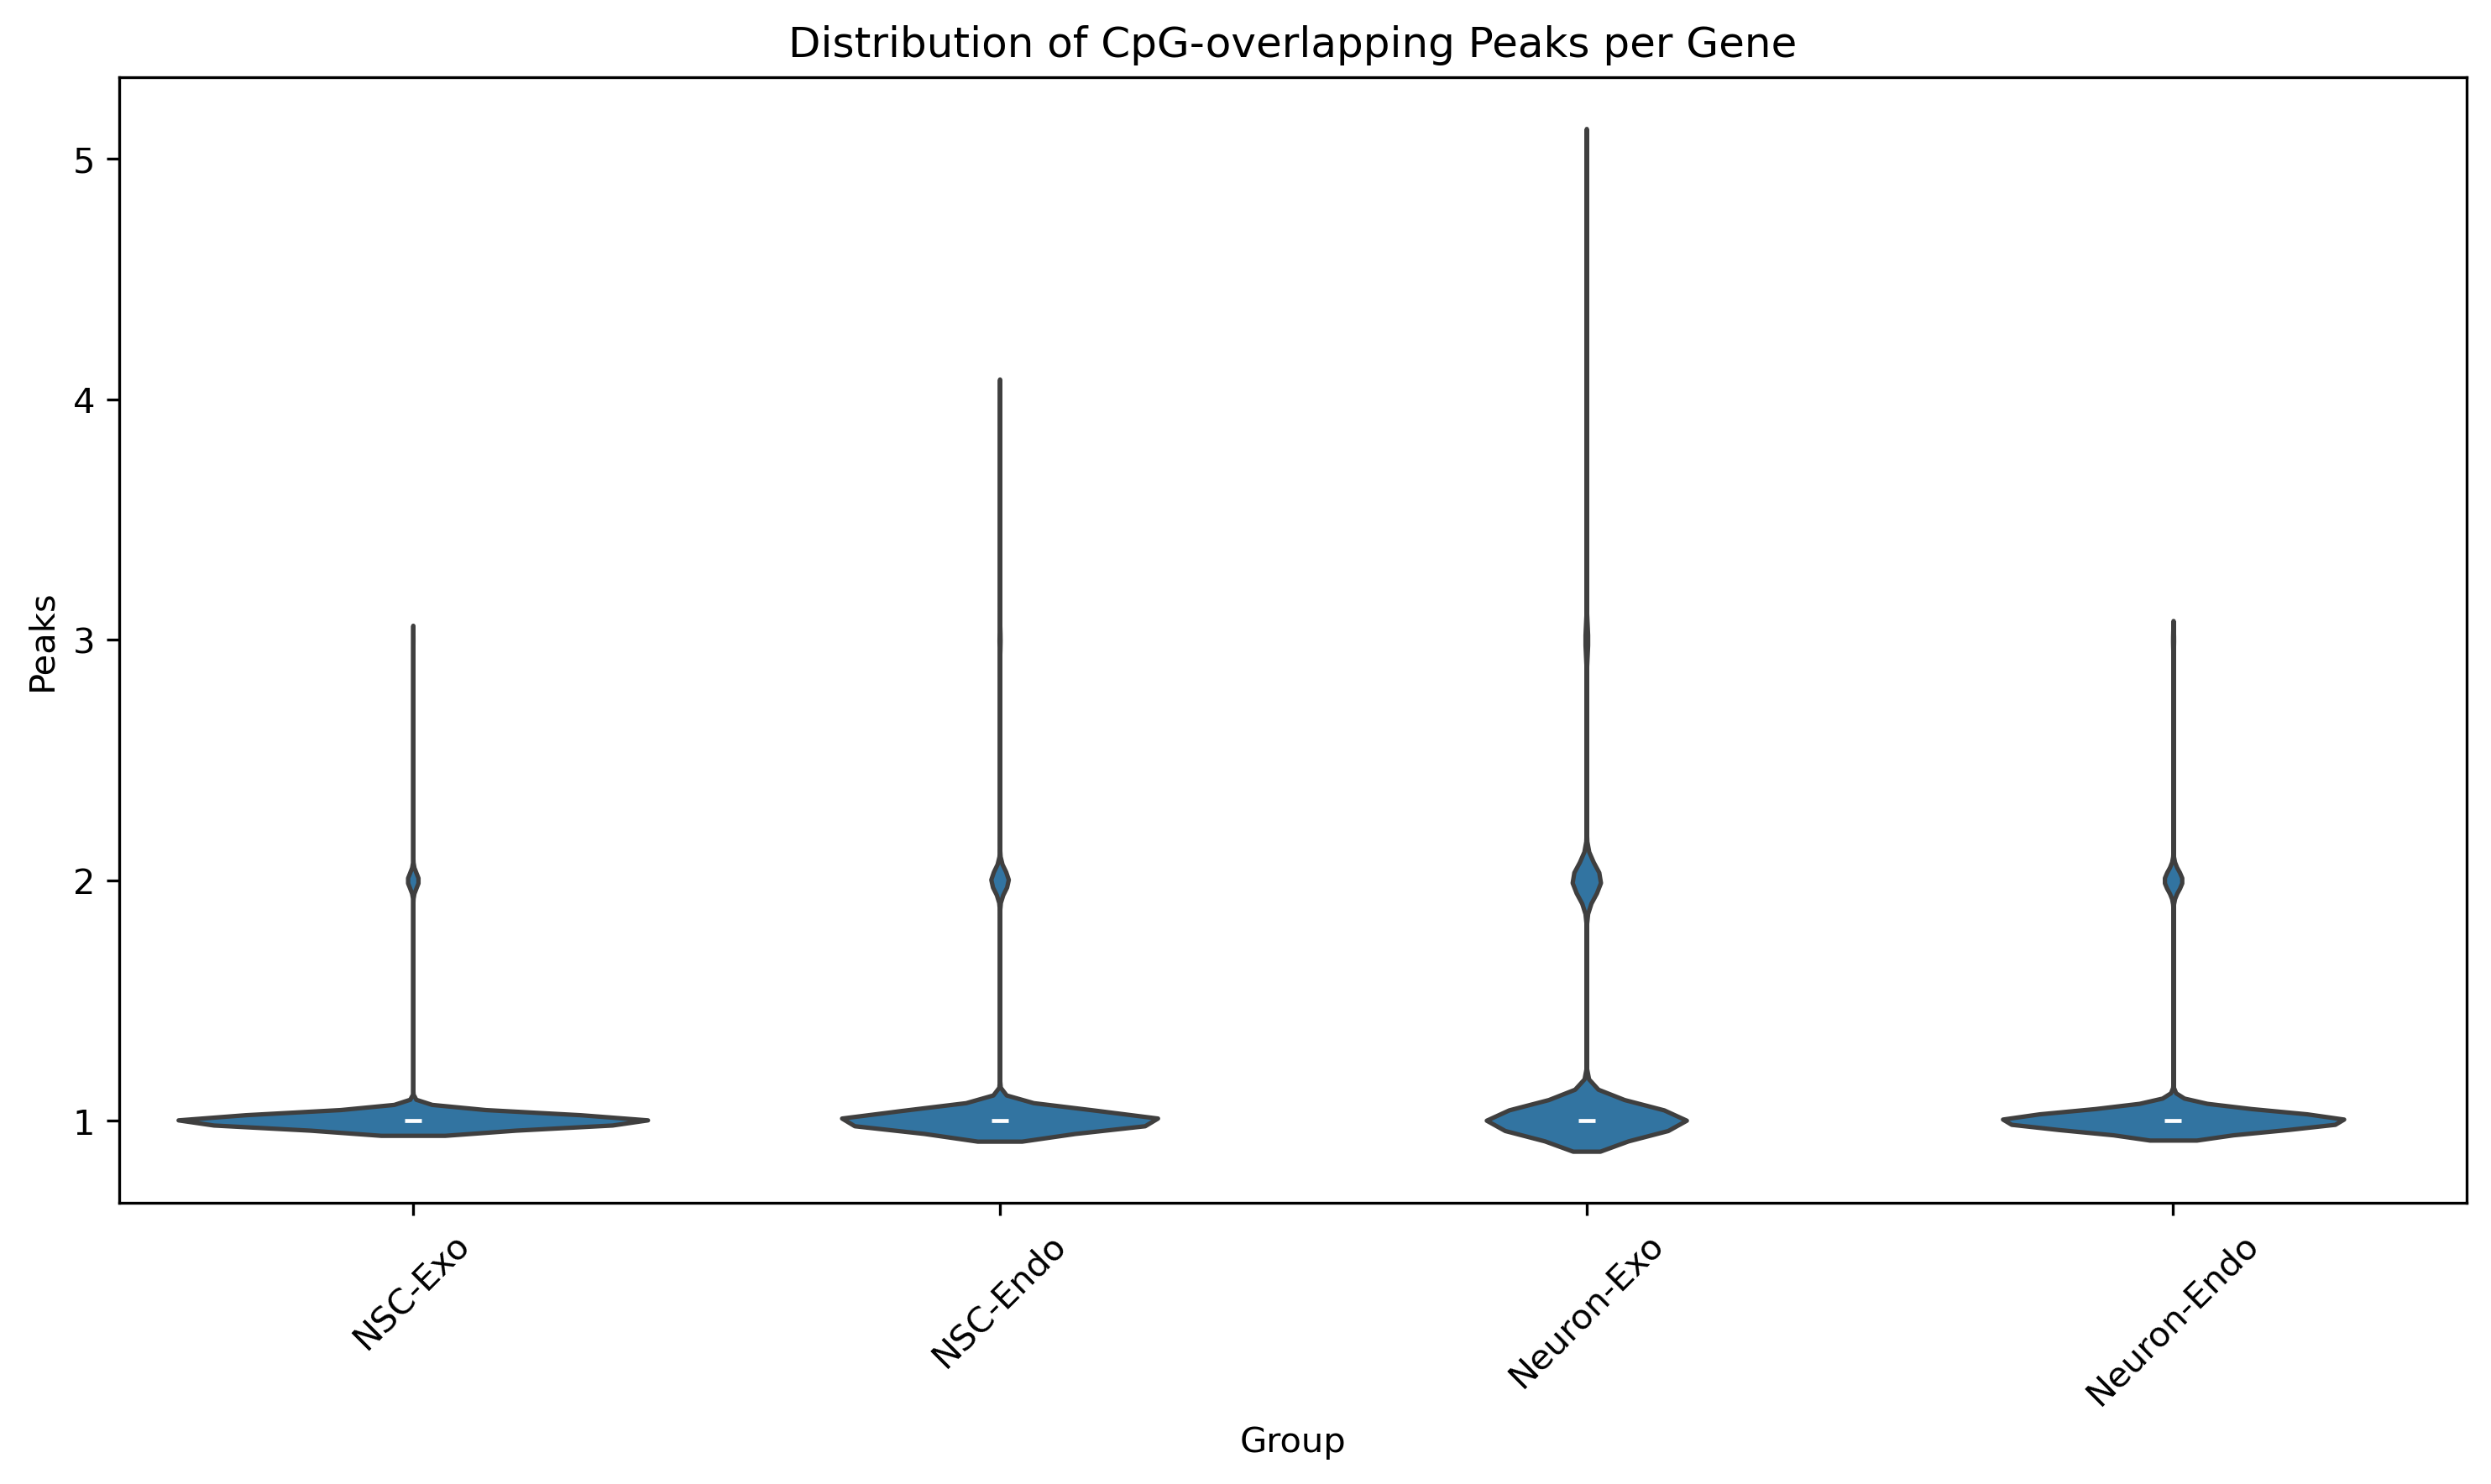

In [11]:
print("Displaying generated visualizations:")
for img_path in glob.glob(f"{visualization_dir}/*.png"):
    print(f"\n{os.path.basename(img_path)}:")
    display(Image(filename=img_path, width=500))


## Visualizations 2

In [9]:
results_dir = "results/cpg_gene_analysis"
analysis_dir = "results/comprehensive_analysis"

generate_comprehensive_analysis(results_dir, analysis_dir)

All analyses have been saved to: results/comprehensive_analysis


<Figure size 1000x1000 with 0 Axes>

Displaying generated visualizations:

endo_cpg_coverage_comparison.png:


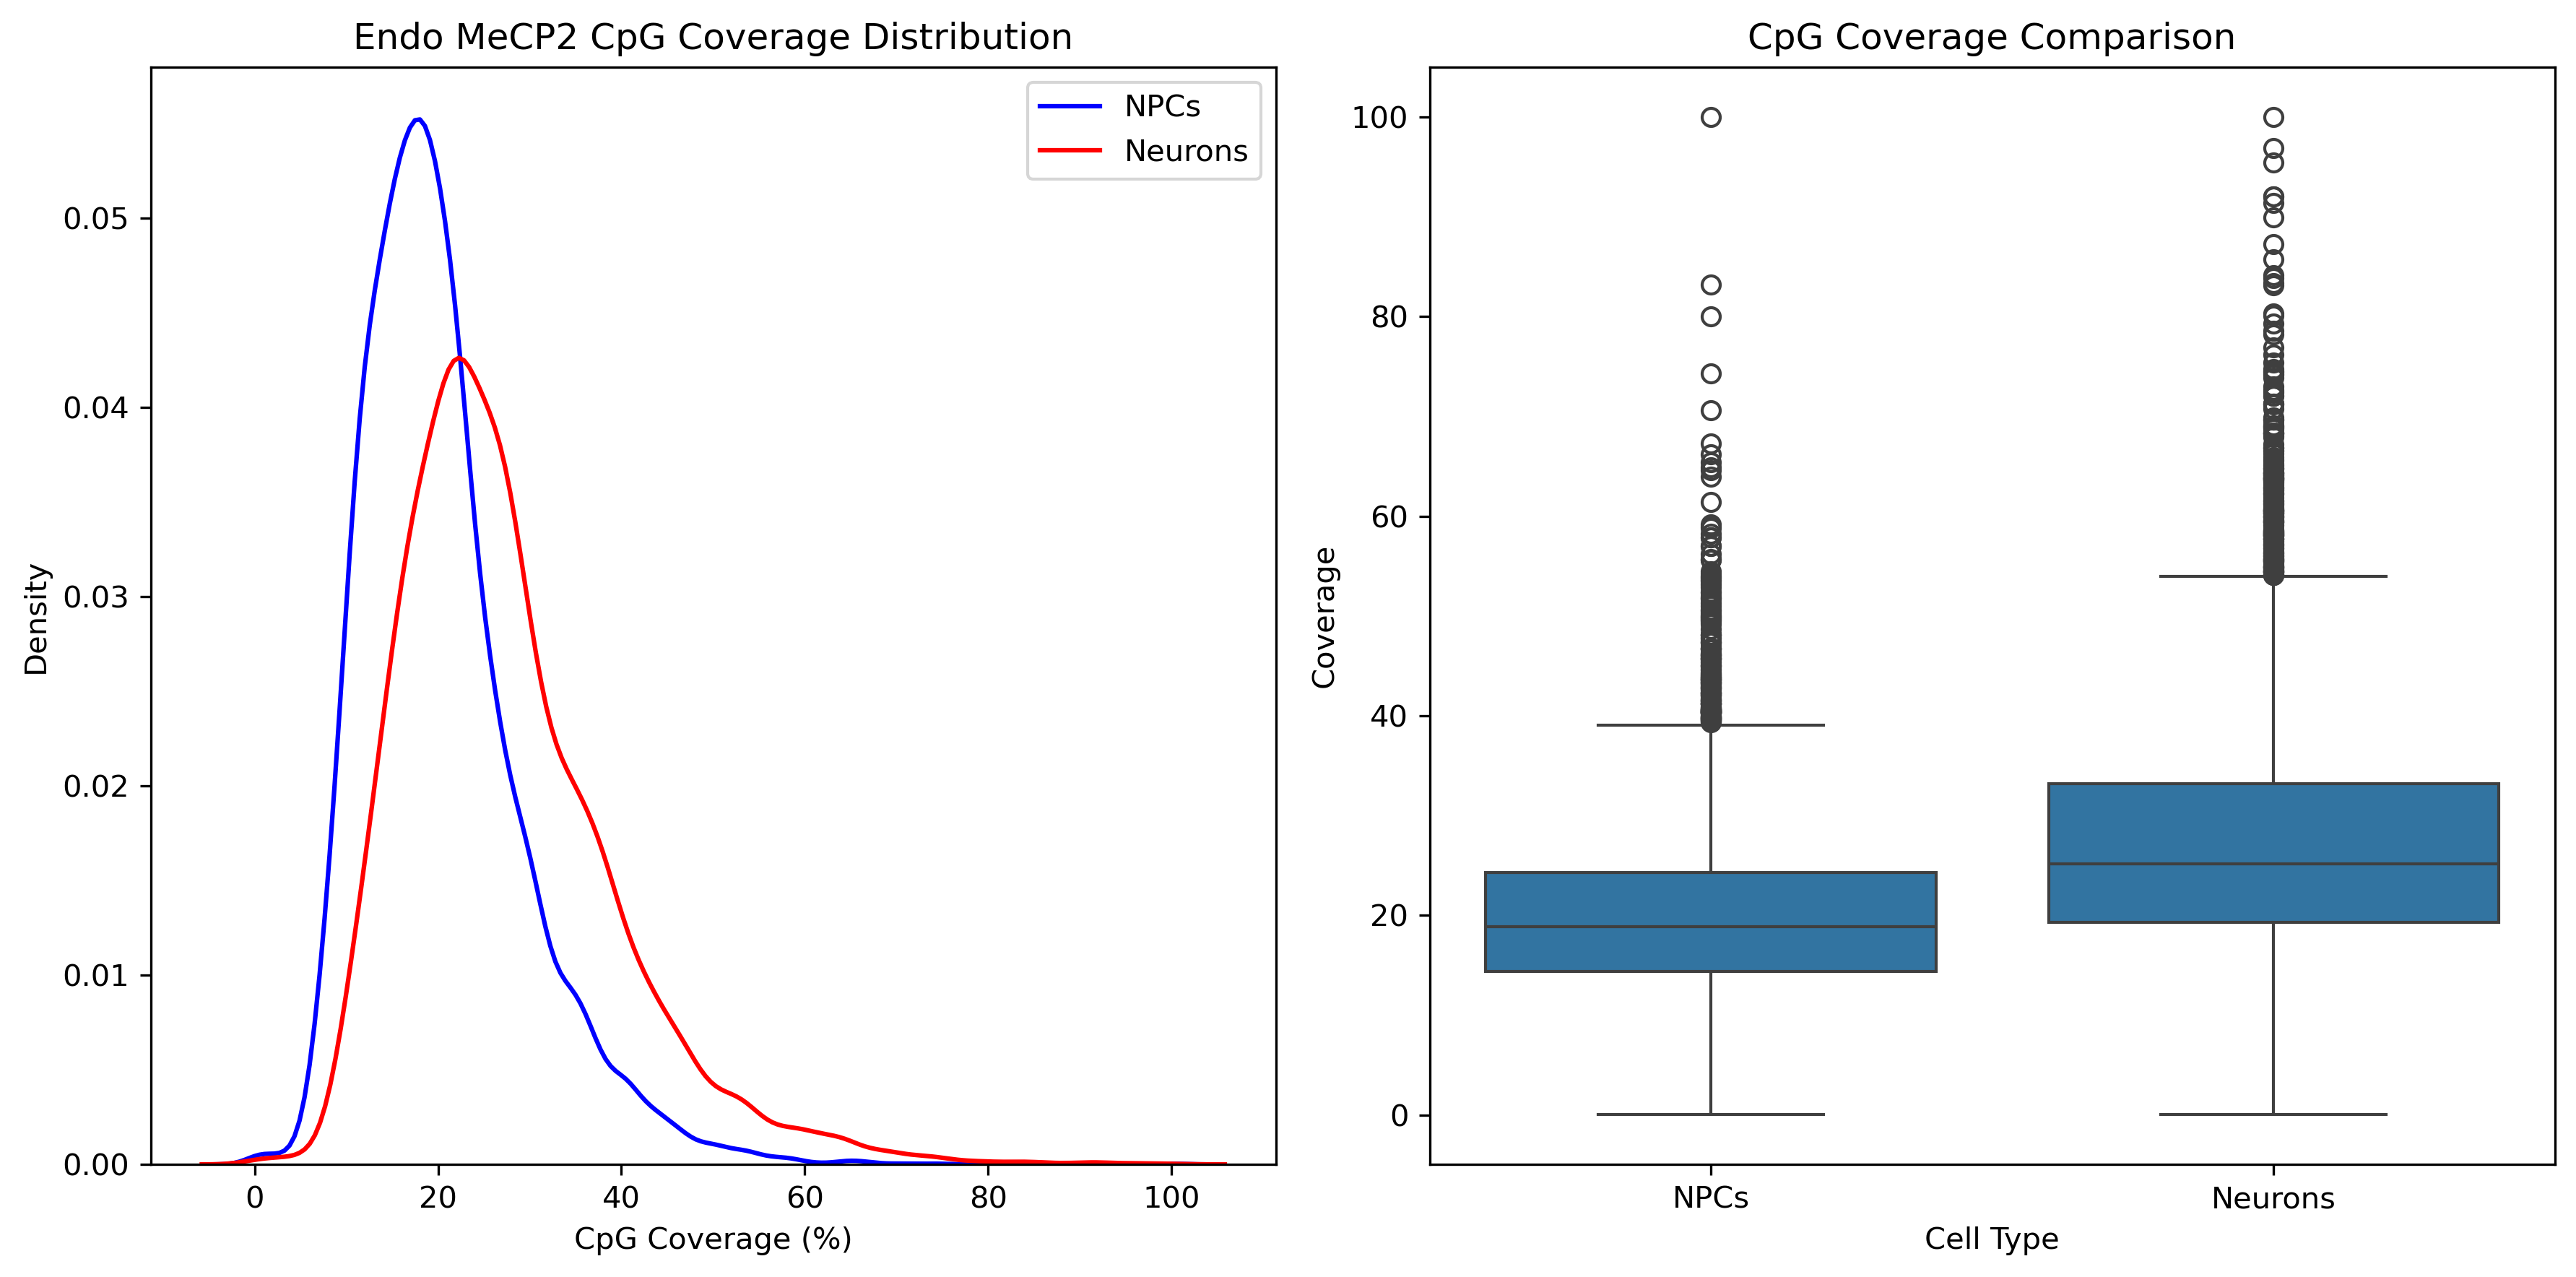


cpg_target_overlap.png:


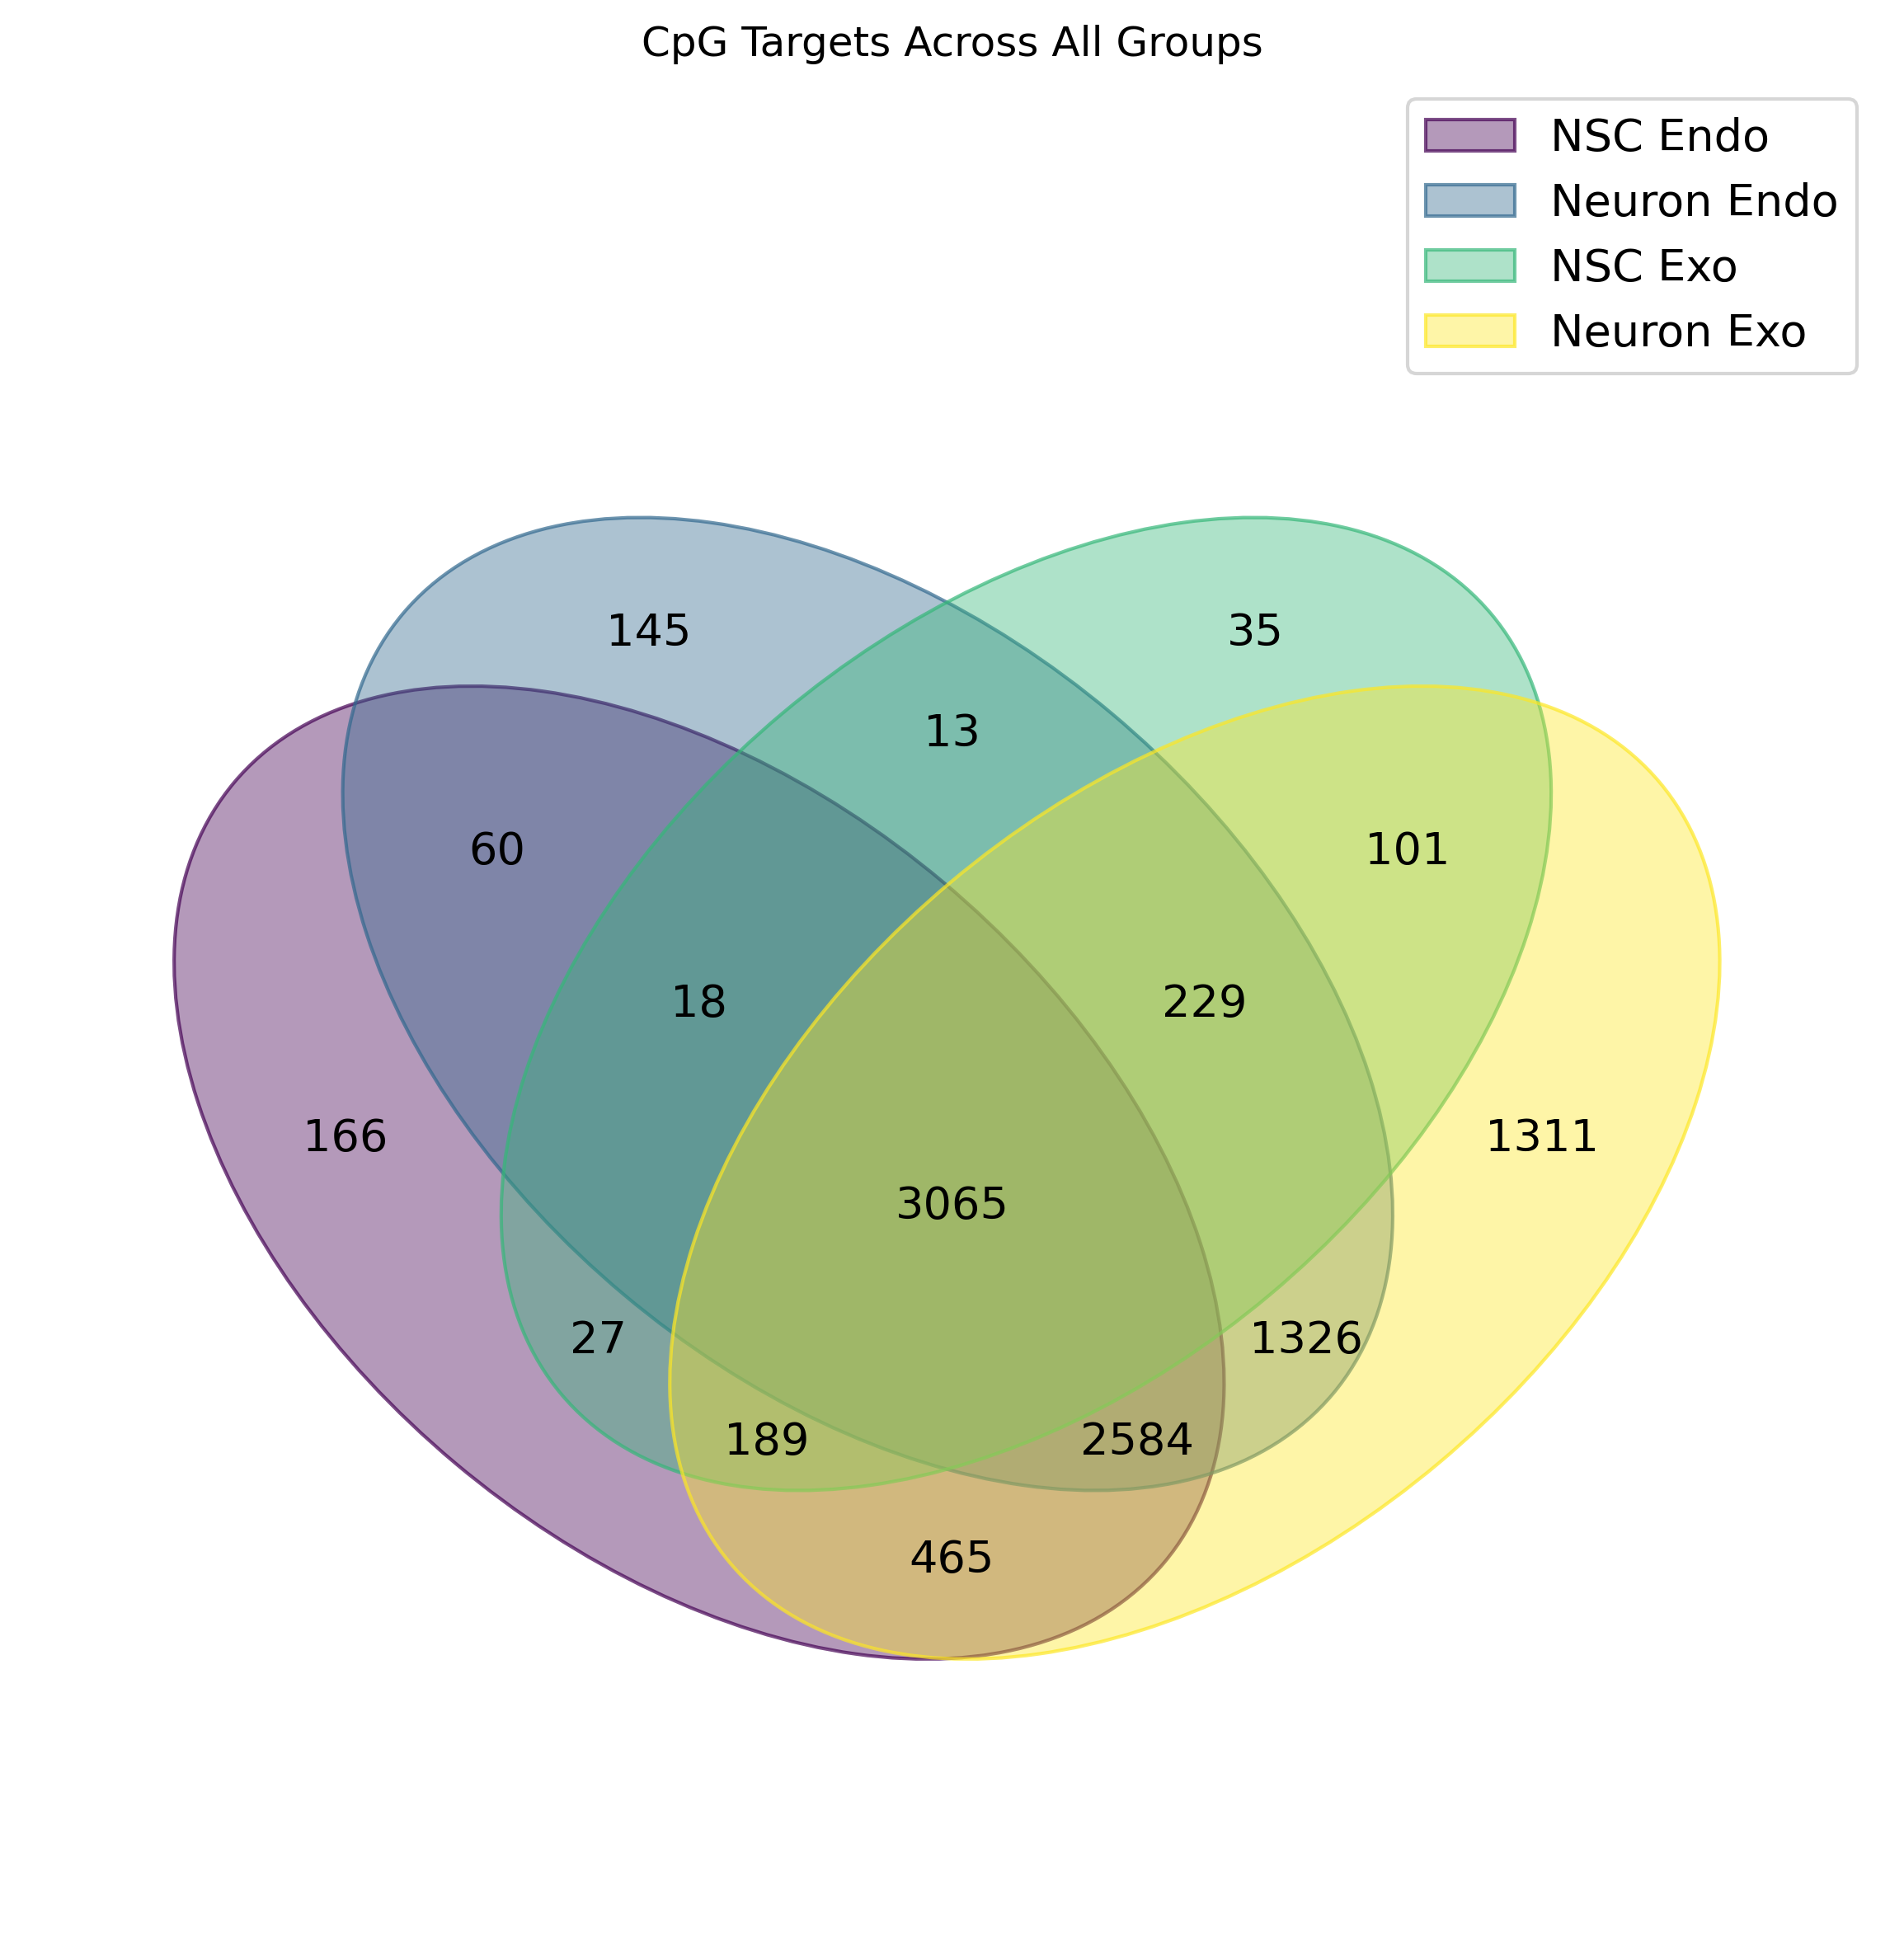

In [10]:
print("Displaying generated visualizations:")
for img_path in glob.glob(f"{analysis_dir}/*.png"):
    print(f"\n{os.path.basename(img_path)}:")
    display(Image(filename=img_path))
